In [ ]:
import pandas as pd
import numpy as np
import os


# read txt file
def read_txt_file(file_path):
    """
    Reads a text file and returns its content as a pandas DataFrame.
    """
    try:
        df = pd.read_csv(file_path, sep=";", header=None)
        return df
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None

data = read_txt_file('data/rayonnement_global/dole.txt')    

: 

In [ ]:
# read the first 5 rows
print(data.head())

In [ ]:
data.columns = ['stn', 'time', 'gre000z0', 'qgre000z0', 'mgre000z0']


In [ ]:
# dort by desc ooder col gre000z0
data = data.sort_values(by='gre000z0', ascending=False)

In [ ]:
# delete col where gre000z0 is 0
data = data[data['gre000z0'] != 0]

In [ ]:
print(data)

In [ ]:
# Ensure gre000z0 is numeric
data['gre000z0'] = pd.to_numeric(data['gre000z0'], errors='coerce')

# Function to get dates where gre000z0 is near zero
def get_near_zero_dates(df, threshold=7):
    """
    Returns the dates where gre000z0 is near to 0.
    """
    near_zero_dates = df[df['gre000z0'] < threshold]['time']
    return near_zero_dates

near_zero_dates = get_near_zero_dates(data)
print("Dates where gre000z0 is near to 0:")
print(near_zero_dates)

In [2]:
from netCDF4 import Dataset

# Open the file
ds = Dataset('data/inca/20230101.nc', mode='r')

# Print file format and global attributes
print("File format:", ds.file_format)
print("\nGlobal attributes:")
for attr in ds.ncattrs():
    print(f"  {attr}: {getattr(ds, attr)}")

# Print dimensions
print("\nDimensions:")
for dim in ds.dimensions.values():
    print(f"  {dim.name}: {len(dim)}")

# Print variables with shape, dimensions, and attributes
print("\nVariables:")
for var_name, var in ds.variables.items():
    print(f"  {var_name}: shape={var.shape}, dims={var.dimensions}")
    for attr in var.ncattrs():
        print(f"    - {attr}: {getattr(var, attr)}")
    # Optionally, print a small sample of data for 1D variables
    if var.ndim == 1:
        print(f"    - sample data: {var[:5]}")
for var_name, var in ds.variables.items():
    print(var_name, getattr(var, 'long_name', ''), getattr(var, 'standard_name', ''))
    
print("x:", ds.variables['x'][:5])
print("y:", ds.variables['y'][:5])

ds.close()

FileNotFoundError: [Errno 2] No such file or directory: 'data/inca/20230101.nc'

## Variables description

- RR --> precipitation (mm/ h)
- TD -->  temperature at which air becomes fully saturated with moisture causing condense (degre)
- PT --> precipitation type (valeur de 0 à 5)
- WG --> coup de vent(m/s)
- TT --> temp à 2 mètre du sol(degres)
- TW --> ?
- CT --> couverture du ciel (%)
- FF --> wind speed(m/s)
- RS --> snowfall(mm/h)
- TG --> Temperature du surface du sol (deg)
- Z0 --> hauteur à la quelle il y le zero term.
- ZS --> hauteur à laquelle il y a la neige
- ZM --> ? 
- SU --> duré relative du soleil (%)
- DD --> direction du vent en dégré
For now for our analysis we can take RR,TD,WG,TT, CT, FF,RS,TG,(ZO), ZS, SU, DD + ! RAYONNEMENT GLOBAL given from IDAWWEB


In [ ]:
import numpy as np
def find_lines_with_coordinates(file_path, x, y, tol=1000):
    """
    Finds and prints all variable values at positions where x and y coordinates match within tolerance.
    """
    ds = Dataset(file_path, mode='r')
    variable_names = ds.variables.keys()
    x_data = ds.variables['x'][:]
    y_data = ds.variables['y'][:]
    x_indices = np.where(np.abs(x_data - x) < tol)[0]
    y_indices = np.where(np.abs(y_data - y) < tol)[0]
    
    print(f"X indices: {x_indices}, Y indices: {y_indices}")
    for xi in x_indices:
        for yi in y_indices:
            print(f"\nValues at x index {xi} (x={x_data[xi]}), y index {yi} (y={y_data[yi]}):")
            for var in variable_names:
                var_obj = ds.variables[var]
                if var_obj.ndim == 2:
                    print(f"{var}: {var_obj[yi, xi]}")
    # pritn 
    ds.close()

find_lines_with_coordinates('data/inca/20230101.nc', 497035., 142375.)

In [ ]:
from pyproj import Transformer
transformer = Transformer.from_crs("4326", "21781")

In [ ]:
a = transformer.transform(46.38318, 6.23955)  # nyon



In [ ]:
print(a)

In [ ]:
from pyproj import Transformer
from netCDF4 import Dataset, num2date
import numpy as np

# Step 1: Convert latitude/longitude to CH1903 / LV03
lat, lon = 46.424797, 6.099136  # Dole coordinates
transformer = Transformer.from_crs("EPSG:4326", "EPSG:21781")
easting, northing = transformer.transform(lat, lon)

print(f"Converted coords: Easting={easting}, Northing={northing}")

# Step 2: Open NetCDF file
nc_path = "data/inca/20230627.nc"  # <-- replace with your actual path
nc = Dataset(nc_path)

# Step 3: Read grid coordinate arrays
x_vals = nc.variables['x'][:]  # shape: (358,)
y_vals = nc.variables['y'][:]  # shape: (232,)

# Step 4: Find closest grid indices
ix = np.argmin(np.abs(x_vals - easting))
iy = np.argmin(np.abs(y_vals - northing))

print(f"Closest grid index -> x: {ix}, y: {iy}")

# Step 5: Read temperature value at time=0
TT = nc.variables['TT']  # or 'TT_ext', depending on what's available
index = 70
temperature = TT[index, iy, ix]  # assuming dimensions are (time, y, x)
# print time
time_var = nc.variables['datetime']

# Get the units from the variable object, not the array
dt0 = num2date(time_var[index], units=time_var.units)
print("Time 0 as datetime:", dt0)

print(f"Temperature at location: {temperature:.2f} °C")


In [ ]:
from netCDF4 import Dataset, num2date

nc = Dataset("data/inca/20230101.nc")
time_var = nc.variables['datetime']

# Get the units from the variable object, not the array
print("Time variable units:", time_var.units)

# Convert the first time value to a datetime object
dt0 = num2date(time_var[0], units=time_var.units)
print("Time 0 as datetime:", dt0)
print("Hour of time 0:", dt0.hour)

nc.close()

In [ ]:
from pyproj import Transformer
from netCDF4 import Dataset, num2date
import numpy as np

# Define your points (lat, lon)
points = {
    "nyon": (46.38318, 6.23955),
    "dole": (46.424797, 6.099136)
}

# Open NetCDF file
nc_path = "data/inca/20230627.nc"
nc = Dataset(nc_path)

x_vals = nc.variables['x'][:]
y_vals = nc.variables['y'][:]

# Prepare transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:21781")

# Extract and convert datetime variable
time_var = nc.variables['datetime']
datetimes = num2date(time_var[:], units=time_var.units)
# Optionally, convert to strings for easier saving/loading
datetimes_str = np.array([dt.isoformat() for dt in datetimes])

# Prepare dictionary to store results
results = {}

for name, (lat, lon) in points.items():
    easting, northing = transformer.transform(lat, lon)
    ix = np.argmin(np.abs(x_vals - easting))
    iy = np.argmin(np.abs(y_vals - northing))
    print(f"{name}: grid index x={ix}, y={iy} (E={easting}, N={northing})")
    
    # Extract all time steps for this point for all 3D variables (time, y, x)
    point_data = {}
    for var_name, var in nc.variables.items():
        if var_name in ['RR', 'TD', 'WG', 'TT', 'CT', 'FF', 'RS', 'TG', 'Z0', 'ZS', 'SU', 'DD']:
            if var.ndim == 3 and var.shape[1:] == (len(y_vals), len(x_vals)):
                point_data[var_name] = var[:, iy, ix]
    # Add datetime array to each point's data
    point_data['datetime'] = datetimes_str
    results[name] = point_data

# Save to compressed npz
np.savez_compressed("nyon_dole_data.npz", **results)

nc.close()

In [ ]:
data = np.load("nyon_dole_data.npz", allow_pickle=True)
print(data.files)
print(data['nyon'].item().keys())  # .item() to get the dict if you saved dicts
print(len(data['nyon'].item()['datetime']))  # Access the datetime array
print(data['nyon'].item()['TT'])  # Access the TT array

# Stratus condition

In [ ]:
# Plotting stratus condition of 20230203
import matplotlib.pyplot as plt
import numpy as np
# read  idaweb_data.npz
date = "2023-03-02"
data = np.load("idaweb_data.npz", allow_pickle=True)
nyon_data = data['nyon'].item()
dole_data = data['dole'].item()
# Get the datetime array
nyon_datetime = nyon_data['datetime']
dole_datetime = dole_data['datetime']
# Get the gre000z0 array
nyon_gre000z0 = nyon_data['gre000z0']
dole_gre000z0 = dole_data['gre000z0']
# filter datetime array for day 20230302
# get ct for 20230302 for nyon and dole
nyon_ct = nyon_data['CT']
dole_ct = dole_data['CT']
# For CT
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_ct = nyon_data['CT'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_ct = dole_data['CT'][dole_mask]

# For nyon
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_gre000z0 = nyon_data['gre000z0'][nyon_mask]

# For dole
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_gre000z0 = dole_data['gre000z0'][dole_mask]

# Convert datetime strings to datetime objects
from datetime import datetime
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_gre000z0, label='Nyon gre000z0', color='blue')
plt.plot(dole_datetime, dole_gre000z0, label='Dole gre000z0', color='red')

plt.xlabel('Date')
plt.ylabel('gre000z0')
plt.title('gre000z0 over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()
# plot on anther graph CT values
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_ct, label='Nyon CT', color='blue')
plt.plot(dole_datetime, dole_ct, label='Dole CT', color='red')
plt.xlabel('Date')
plt.ylabel('CT')
plt.title('CT over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()

# search and plot td valuues of dole and nyon
# For TD
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_td =nyon_data['TT'][nyon_mask]- nyon_data['TD'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_td = dole_data['TT'][dole_mask]-dole_data['TD'][dole_mask]
# Convert datetime strings to datetime objects
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_td, label='Nyon TD', color='blue')
plt.plot(dole_datetime, dole_td, label='Dole TD', color='red')
plt.xlabel('Date')
plt.ylabel('TD')
plt.title('TD over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()

# FOR SU
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_su = nyon_data['SU'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_su = dole_data['SU'][dole_mask]
# Convert datetime strings to datetime objects
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_su, label='Nyon SU', color='blue')
plt.plot(dole_datetime, dole_su, label='Dole SU', color='red')
plt.xlabel('Date')
plt.ylabel('SU')
plt.title('SU over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()


 # Half stratus condition

In [ ]:
# Plotting stratus condition of 20230203
import matplotlib.pyplot as plt
import numpy as np
# read  idaweb_data.npz
date = "2023-03-07"
data = np.load("idaweb_data.npz", allow_pickle=True)
nyon_data = data['nyon'].item()
dole_data = data['dole'].item()
# Get the datetime array
nyon_datetime = nyon_data['datetime']
dole_datetime = dole_data['datetime']
# Get the gre000z0 array
nyon_gre000z0 = nyon_data['gre000z0']
dole_gre000z0 = dole_data['gre000z0']
# filter datetime array for day 20230302
# get ct for 20230302 for nyon and dole
nyon_ct = nyon_data['CT']
dole_ct = dole_data['CT']
# For CT
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_ct = nyon_data['CT'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_ct = dole_data['CT'][dole_mask]

# For nyon
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_gre000z0 = nyon_data['gre000z0'][nyon_mask]

# For dole
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_gre000z0 = dole_data['gre000z0'][dole_mask]

# Convert datetime strings to datetime objects
from datetime import datetime
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_gre000z0, label='Nyon gre000z0', color='blue')
plt.plot(dole_datetime, dole_gre000z0, label='Dole gre000z0', color='red')

plt.xlabel('Date')
plt.ylabel('gre000z0')
plt.title('gre000z0 over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()
# plot on anther graph CT values
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_ct, label='Nyon CT', color='blue')
plt.plot(dole_datetime, dole_ct, label='Dole CT', color='red')
plt.xlabel('Date')
plt.ylabel('CT')
plt.title('CT over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()

# search and plot td valuues of dole and nyon
# For TD
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_td = nyon_data['TD'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_td = dole_data['TD'][dole_mask]
# Convert datetime strings to datetime objects
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_td, label='Nyon TD', color='blue')
plt.plot(dole_datetime, dole_td, label='Dole TD', color='red')
plt.xlabel('Date')
plt.ylabel('TD')
plt.title('TD over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()
# FOR SU
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_su = nyon_data['SU'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_su = dole_data['SU'][dole_mask]
# Convert datetime strings to datetime objects
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_su, label='Nyon SU', color='blue')
plt.plot(dole_datetime, dole_su, label='Dole SU', color='red')
plt.xlabel('Date')
plt.ylabel('SU')
plt.title('SU over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()


# Sunny condition

In [ ]:
# Plotting stratus condition of 20230203
import matplotlib.pyplot as plt
import numpy as np
# read  idaweb_data.npz
date = "2023-03-16"
data = np.load("idaweb_data.npz", allow_pickle=True)
nyon_data = data['nyon'].item()
dole_data = data['dole'].item()
# Get the datetime array
nyon_datetime = nyon_data['datetime']
dole_datetime = dole_data['datetime']
# Get the gre000z0 array
nyon_gre000z0 = nyon_data['gre000z0']
dole_gre000z0 = dole_data['gre000z0']
# filter datetime array for day 20230302
# get ct for 20230302 for nyon and dole
nyon_ct = nyon_data['CT']
dole_ct = dole_data['CT']
# For CT
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_ct = nyon_data['CT'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_ct = dole_data['CT'][dole_mask]

# For nyon
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_gre000z0 = nyon_data['gre000z0'][nyon_mask]

# For dole
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_gre000z0 = dole_data['gre000z0'][dole_mask]

# Convert datetime strings to datetime objects
from datetime import datetime
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_gre000z0, label='Nyon gre000z0', color='blue')
plt.plot(dole_datetime, dole_gre000z0, label='Dole gre000z0', color='red')

plt.xlabel('Date')
plt.ylabel('gre000z0')
plt.title('gre000z0 over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()
# plot on anther graph CT values
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_ct, label='Nyon CT', color='blue')
plt.plot(dole_datetime, dole_ct, label='Dole CT', color='red')
plt.xlabel('Date')
plt.ylabel('CT')
plt.title('CT over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()

# search and plot td valuues of dole and nyon
# For TD
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_td = nyon_data['TD'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_td = dole_data['TD'][dole_mask]
# Convert datetime strings to datetime objects
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_td, label='Nyon TD', color='blue')
plt.plot(dole_datetime, dole_td, label='Dole TD', color='red')
plt.xlabel('Date')
plt.ylabel('TD')
plt.title('TD over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()
# FOR SU
nyon_mask = [dt.startswith(date) for dt in nyon_data['datetime']]
nyon_datetime = [dt for dt, keep in zip(nyon_data['datetime'], nyon_mask) if keep]
nyon_su = nyon_data['SU'][nyon_mask]
dole_mask = [dt.startswith(date) for dt in dole_data['datetime']]
dole_datetime = [dt for dt, keep in zip(dole_data['datetime'], dole_mask) if keep]
dole_su = dole_data['SU'][dole_mask]
# Convert datetime strings to datetime objects
nyon_datetime = [datetime.fromisoformat(dt) for dt in nyon_datetime]
dole_datetime = [datetime.fromisoformat(dt) for dt in dole_datetime]
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nyon_datetime, nyon_su, label='Nyon SU', color='blue')
plt.plot(dole_datetime, dole_su, label='Dole SU', color='red')
plt.xlabel('Date')
plt.ylabel('SU')
plt.title('SU over time for Nyon and Dole')
plt.xticks(rotation=45)
plt.legend()


: 

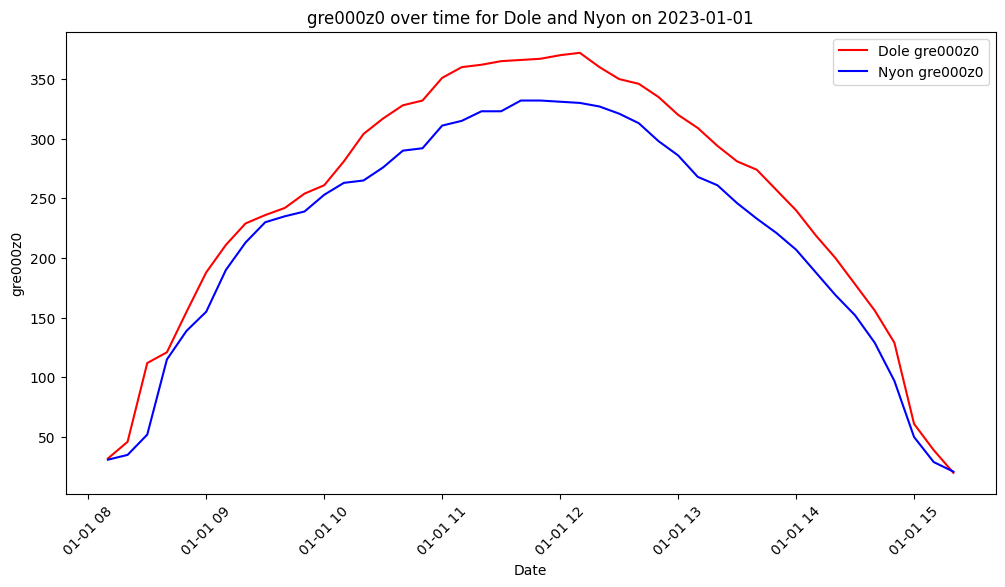

In [28]:
# read npz data train file

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
npz_data = np.load("data/complete_data.npz", allow_pickle=True)
# read gre000z0 dole values
data = npz_data['dole']
dole_gre000z0 = {}
nyon_gre000z0 = {}
for i in range(len(data)):
    # get the gre000z0 values
    gre000z0_dole = data[i]['gre000z0_dole']
    gre000z0_nyon = data[i]['gre000z0_nyon']
    # append to the list
    dole_gre000z0[data[i]["datetime"]] = gre000z0_dole
    nyon_gre000z0[data[i]["datetime"]] = gre000z0_nyon
# group data by date
dole_gre000z0 = pd.DataFrame.from_dict(dole_gre000z0, orient='index', columns=['gre000z0'])
nyon_gre000z0 = pd.DataFrame.from_dict(nyon_gre000z0, orient='index', columns=['gre000z0'])
# convert index to datetime
dole_gre000z0.index = pd.to_datetime(dole_gre000z0.index)
nyon_gre000z0.index = pd.to_datetime(nyon_gre000z0.index)
# sort by date
dole_gre000z0 = dole_gre000z0.sort_index()
nyon_gre000z0 = nyon_gre000z0.sort_index()
# Filter data for the specific date
dole_gre000z0_filtered = dole_gre000z0.loc['2023-01-01']
nyon_gre000z0_filtered = nyon_gre000z0.loc['2023-01-01']

# Plot the filtered data
plt.figure(figsize=(12, 6))
plt.plot(dole_gre000z0_filtered.index, dole_gre000z0_filtered['gre000z0'], label='Dole gre000z0', color='red')
plt.plot(nyon_gre000z0_filtered.index, nyon_gre000z0_filtered['gre000z0'], label='Nyon gre000z0', color='blue')
plt.xlabel('Date')
plt.ylabel('gre000z0')
plt.title('gre000z0 over time for Dole and Nyon on 2023-01-01')
plt.xticks(rotation=45)
plt.legend()
plt.show()


2023-01-01     25.0
2023-01-02    -32.0
2023-01-03     32.0
2023-01-04    -42.5
2023-01-05    -10.0
              ...  
2024-12-24     52.0
2024-12-25      0.0
2024-12-26    193.0
2024-12-27    245.5
2024-12-28    241.0
Freq: D, Length: 728, dtype: float64


/tmp/ipykernel_113325/366025702.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


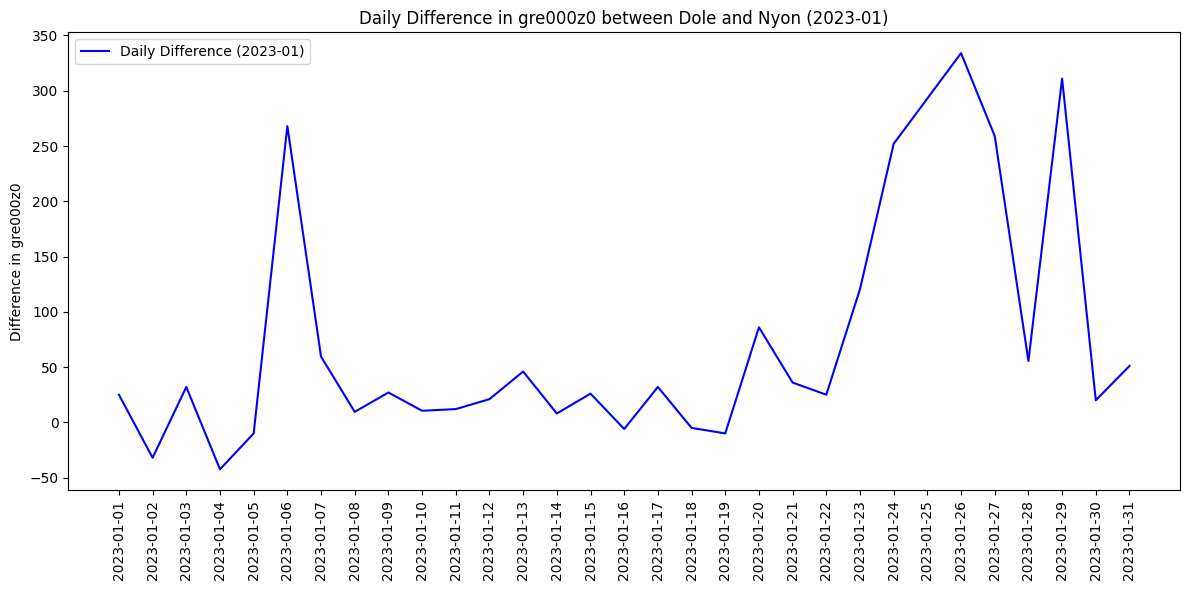

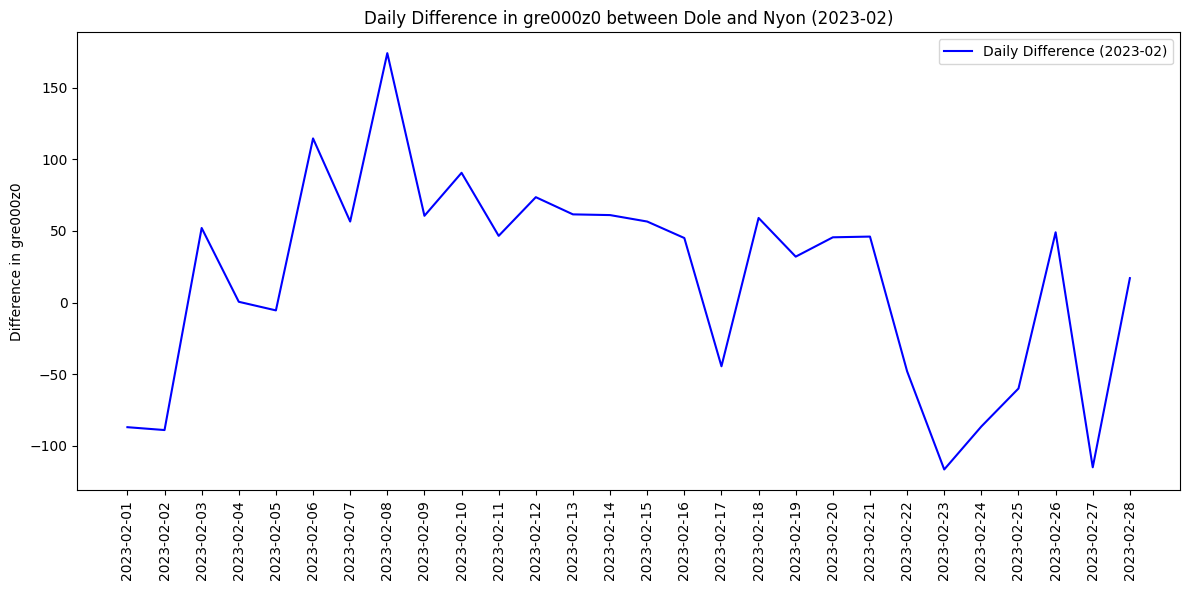

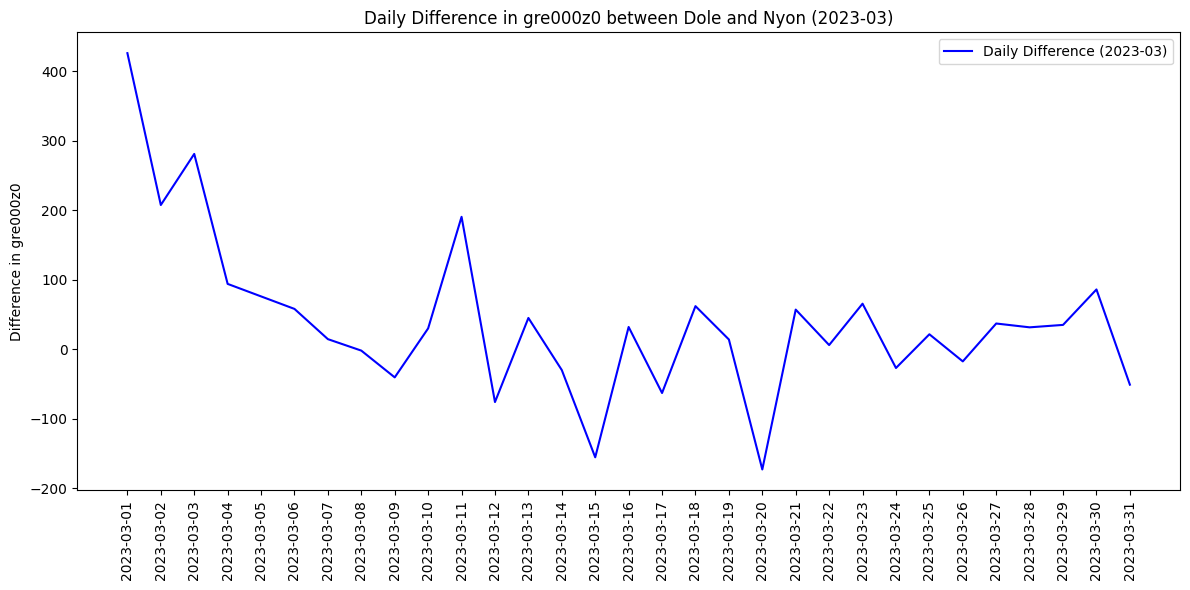

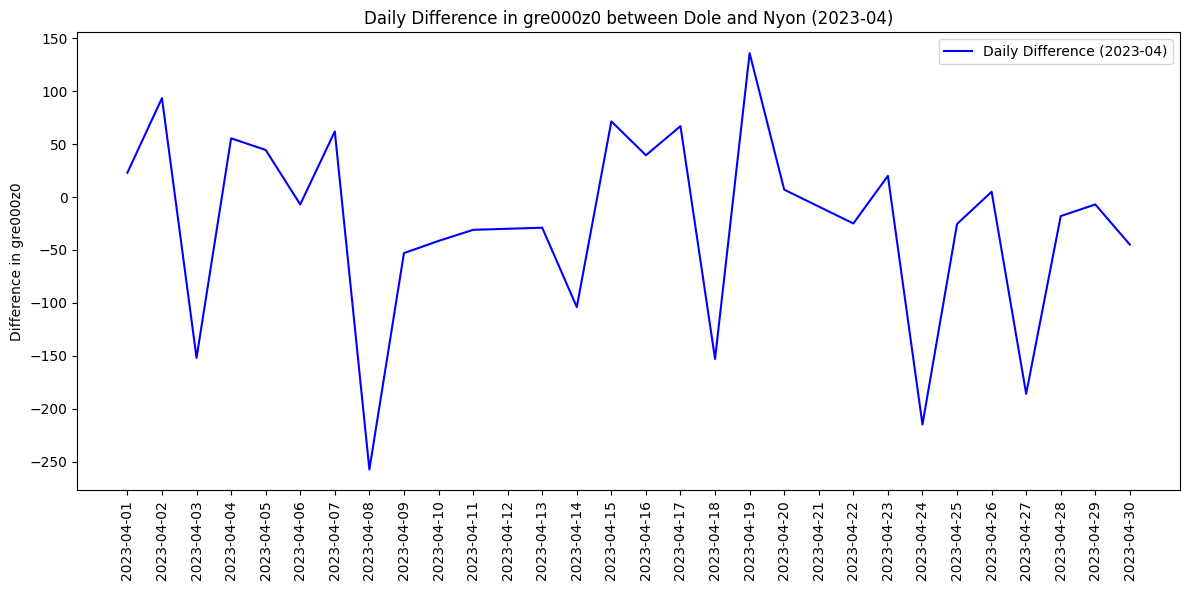

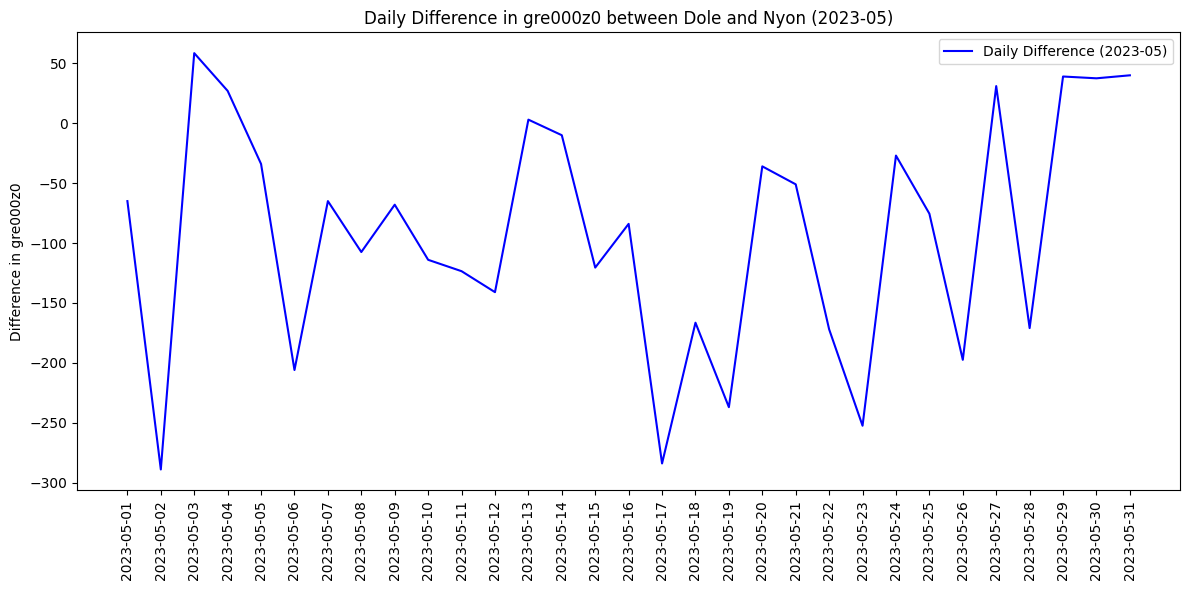

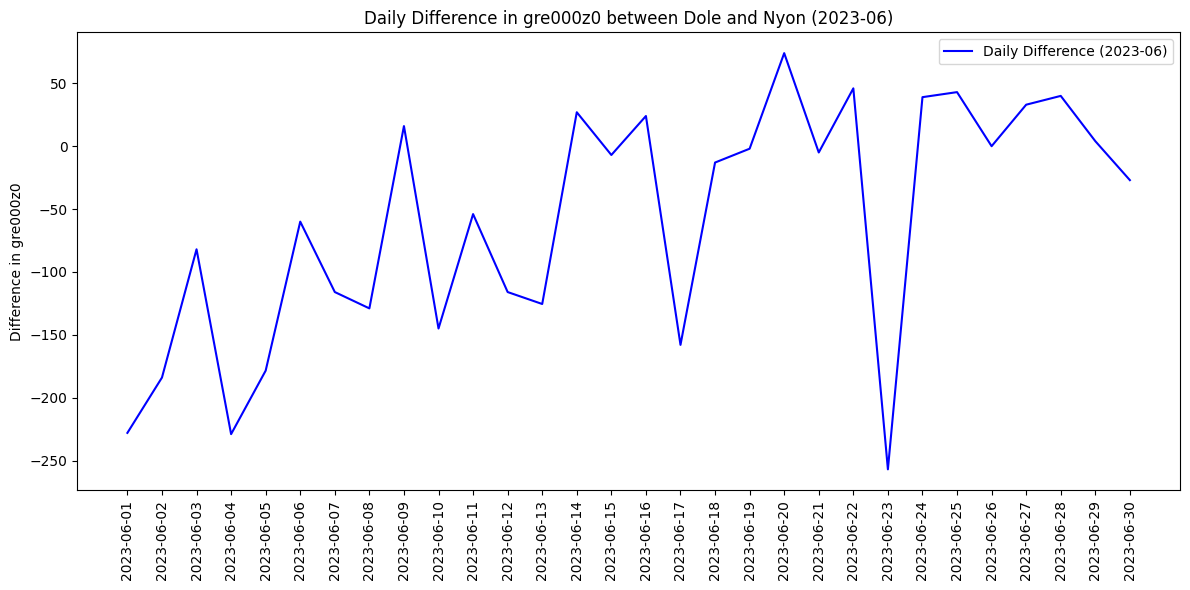

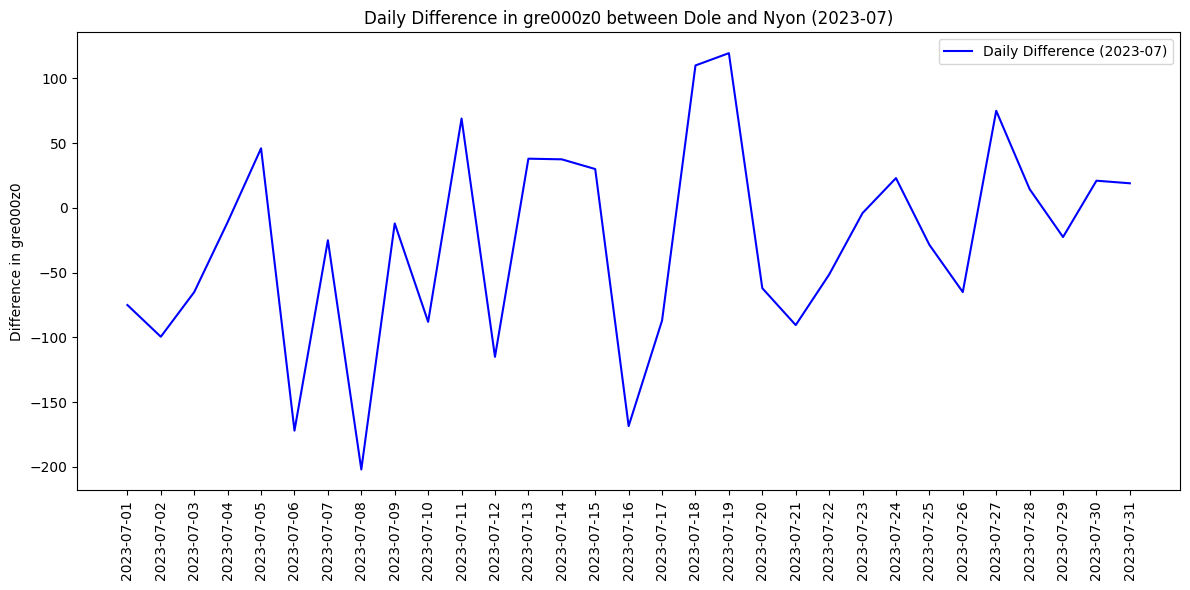

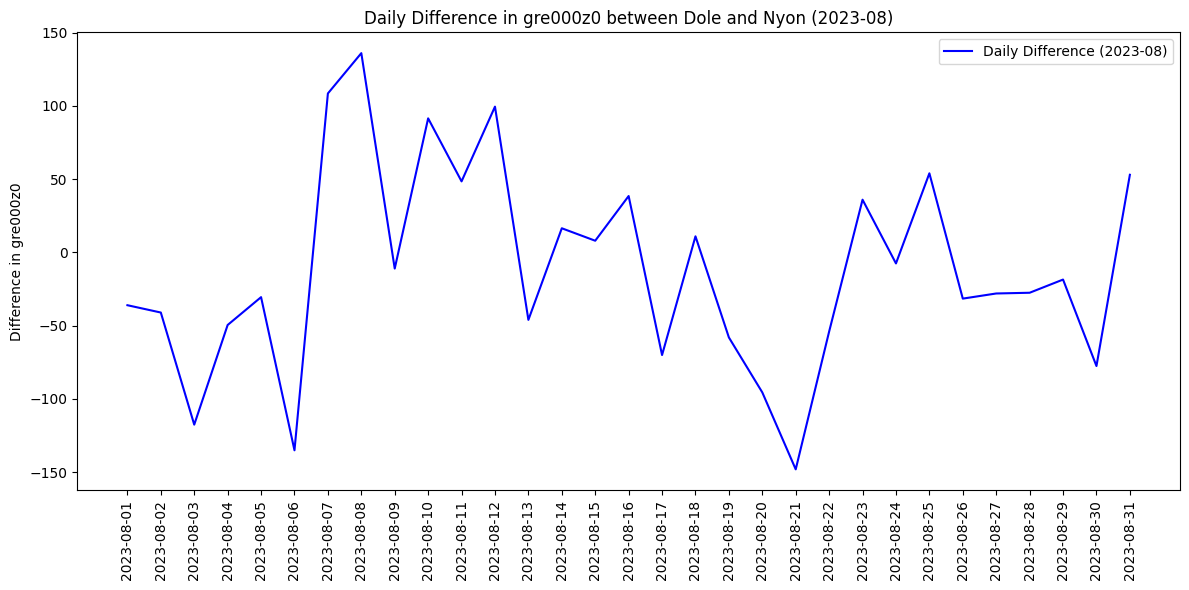

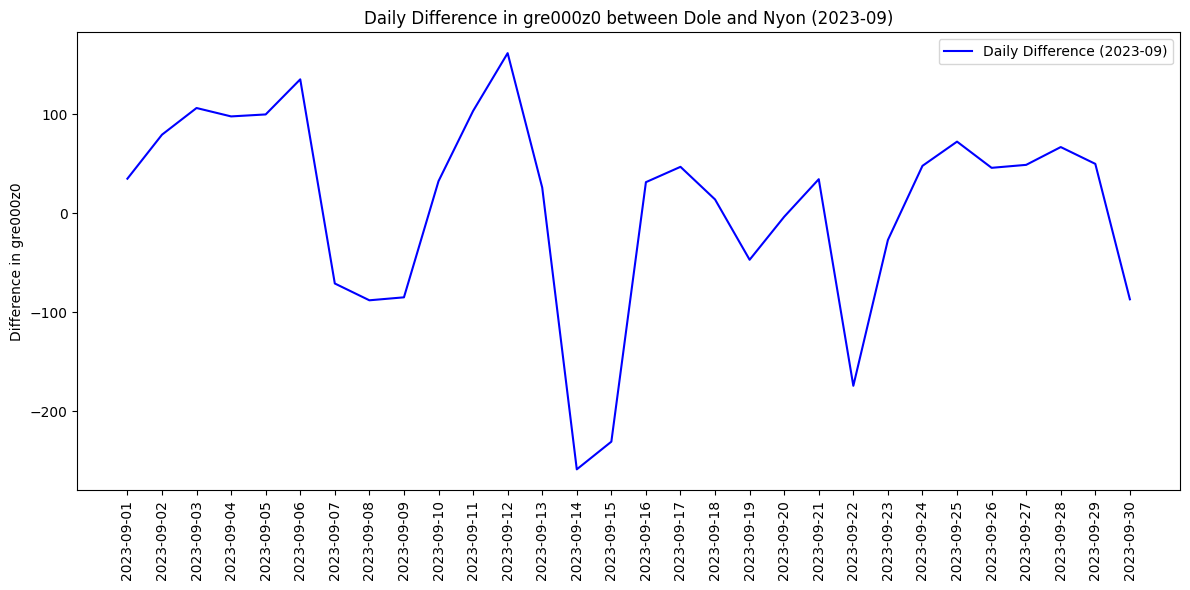

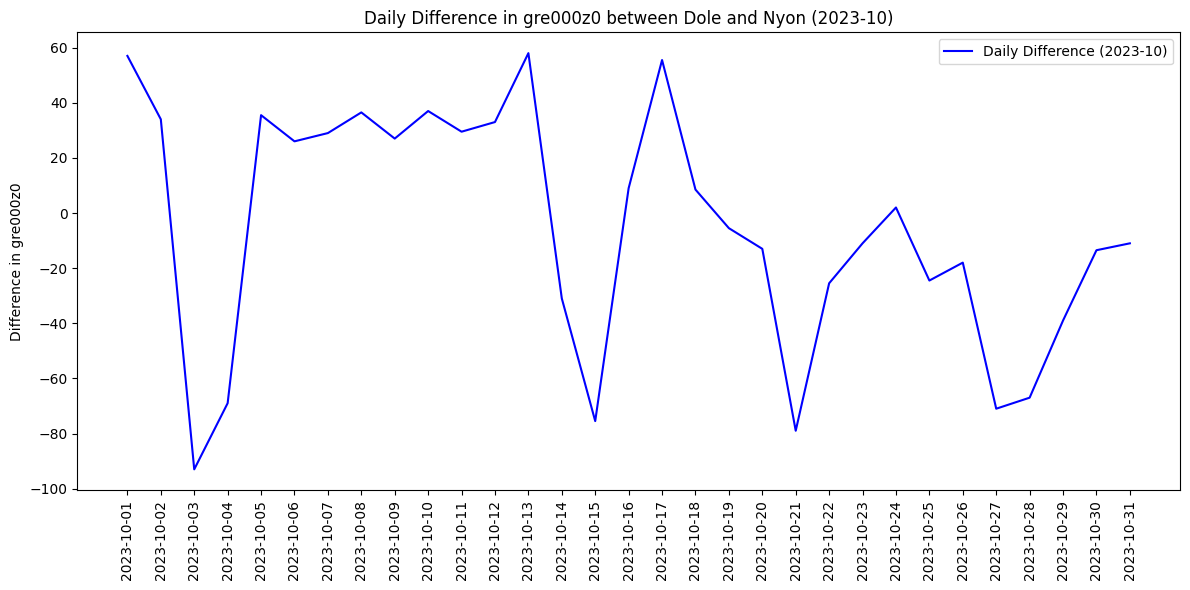

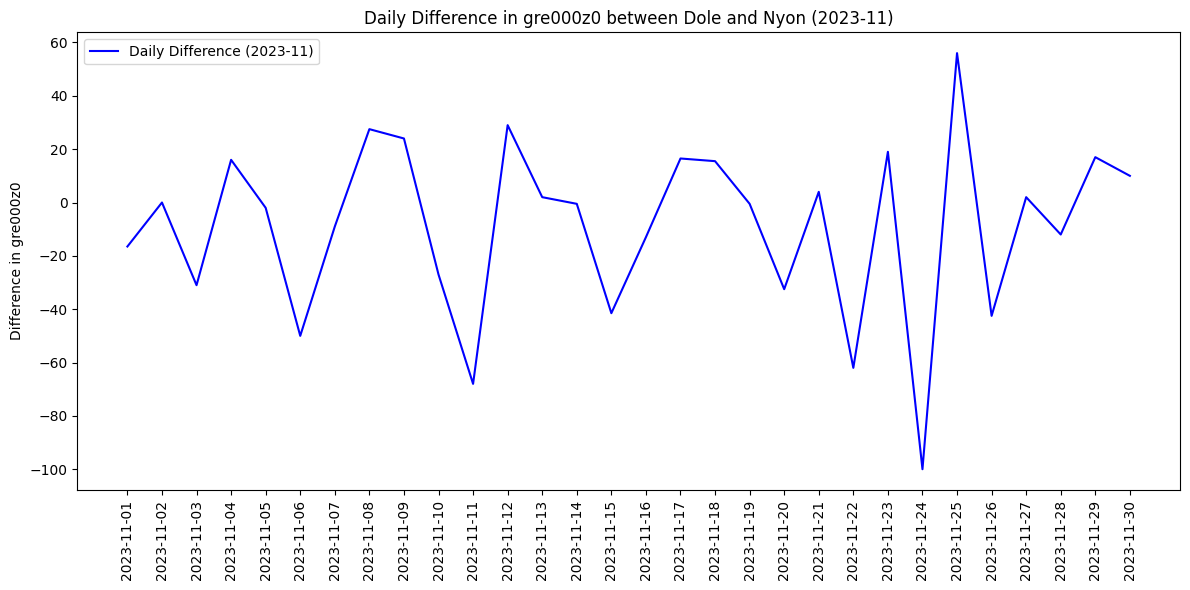

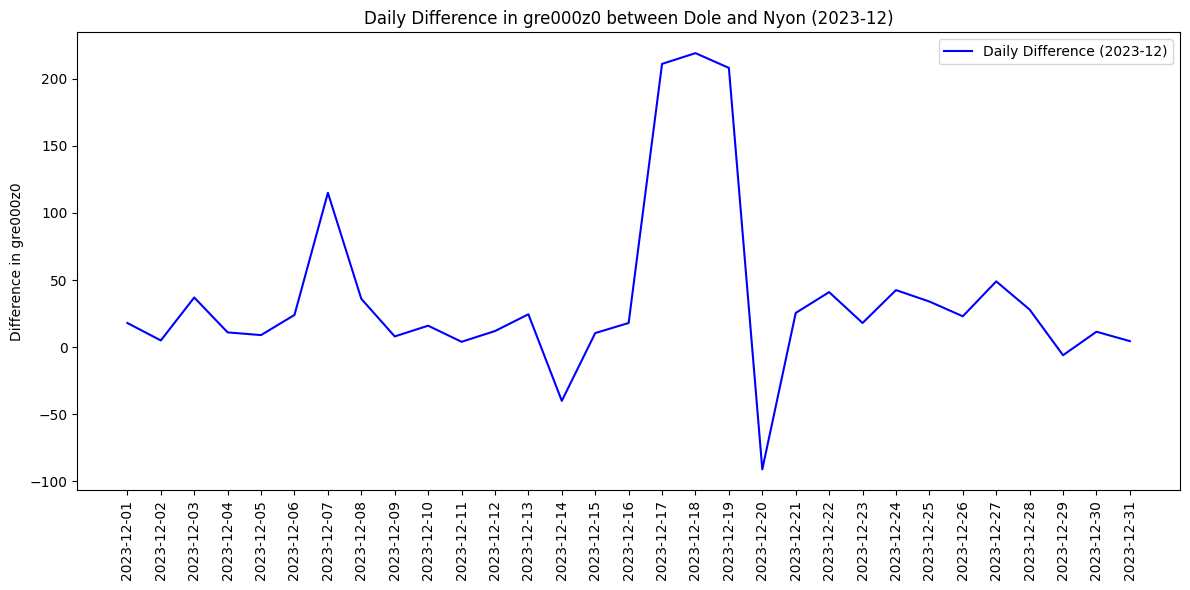

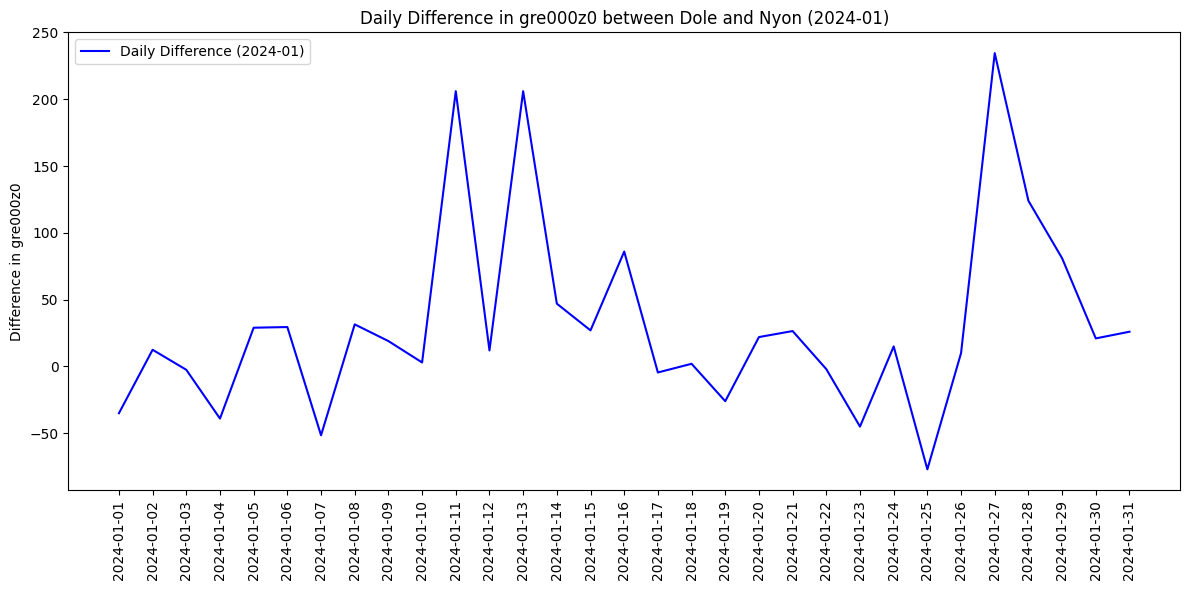

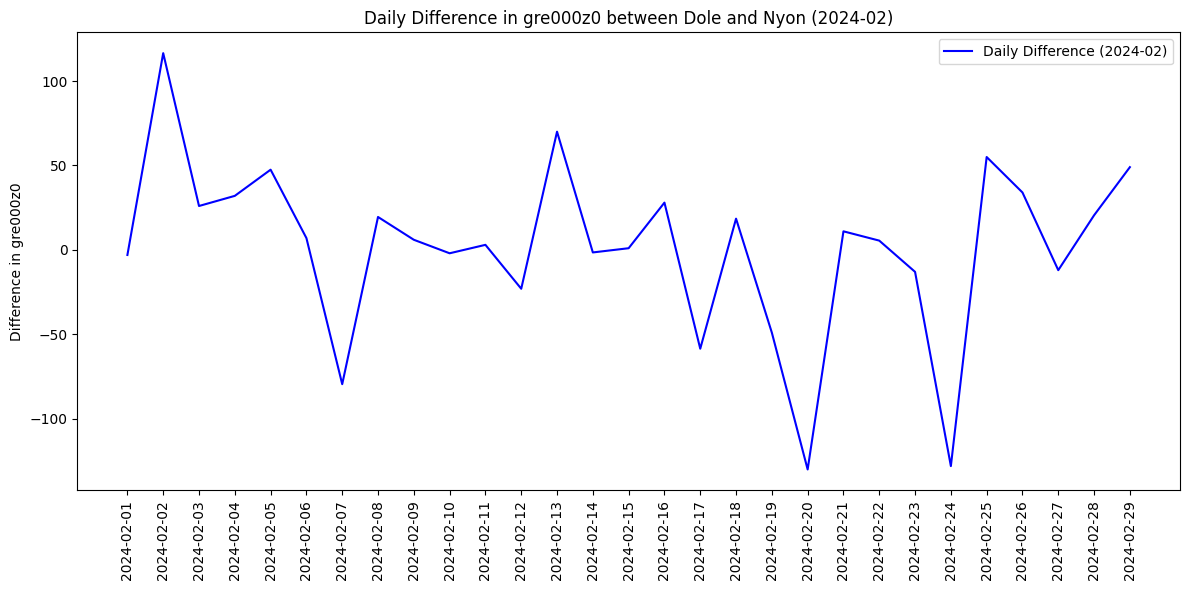

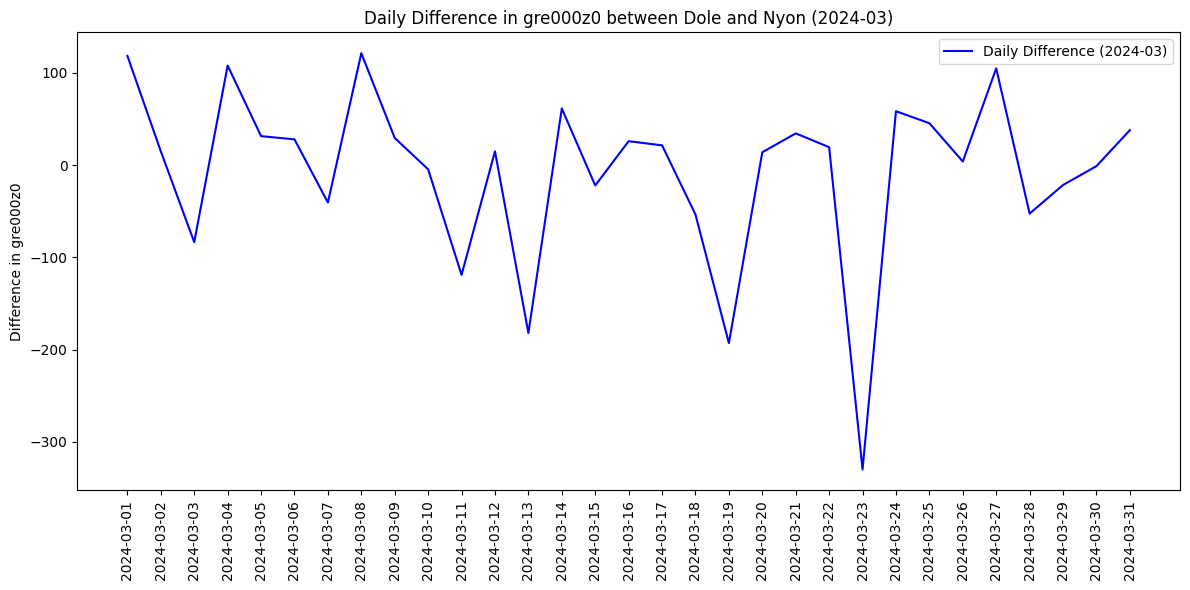

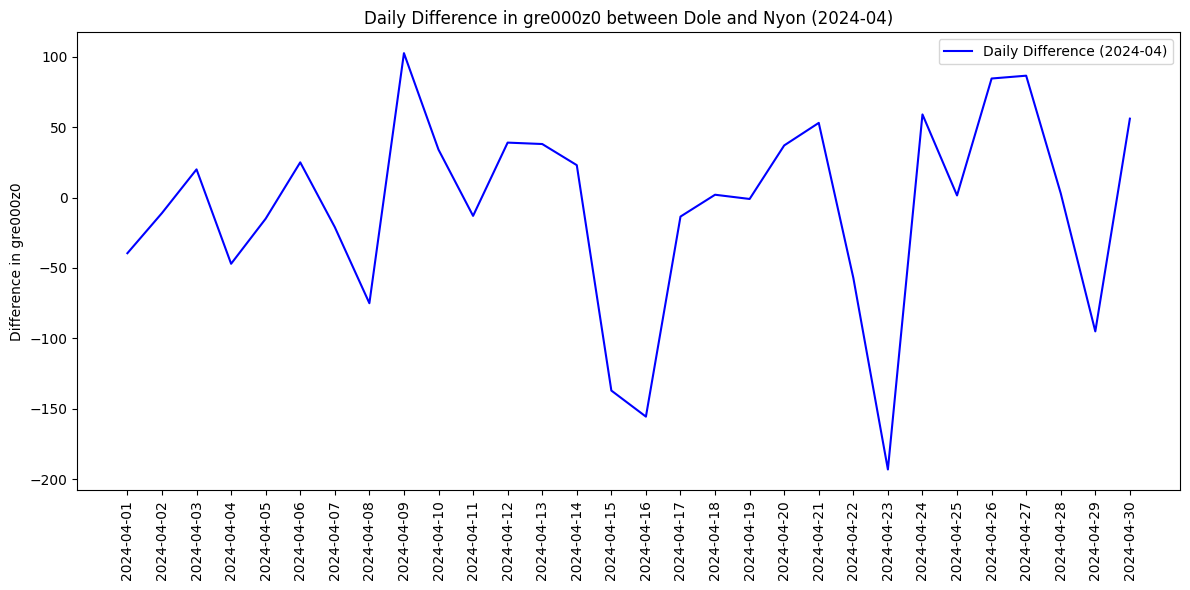

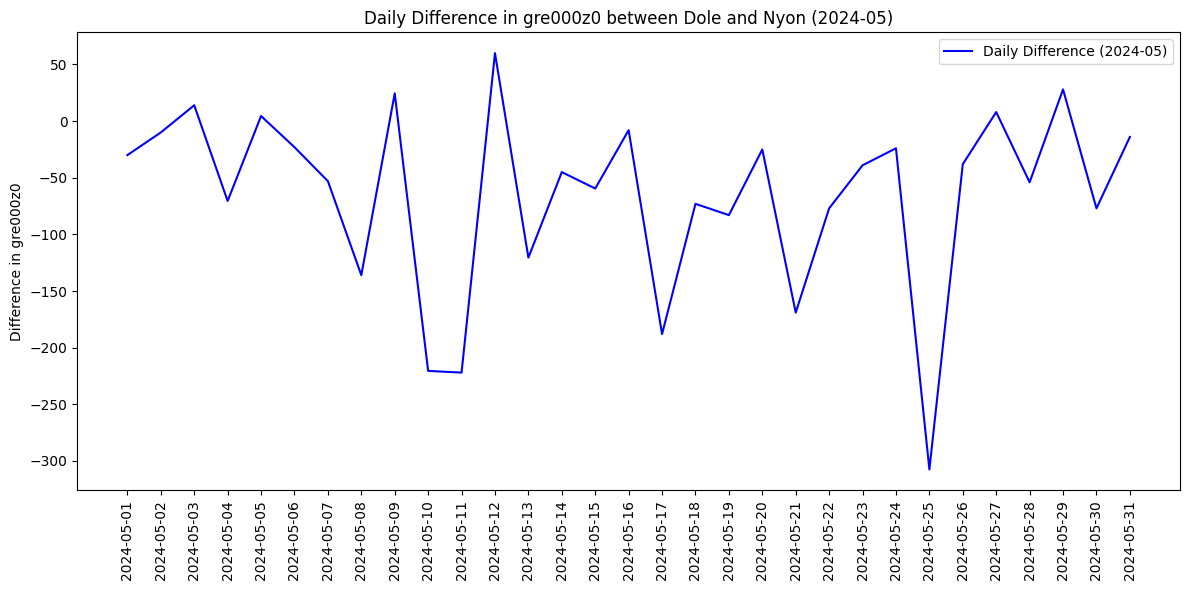

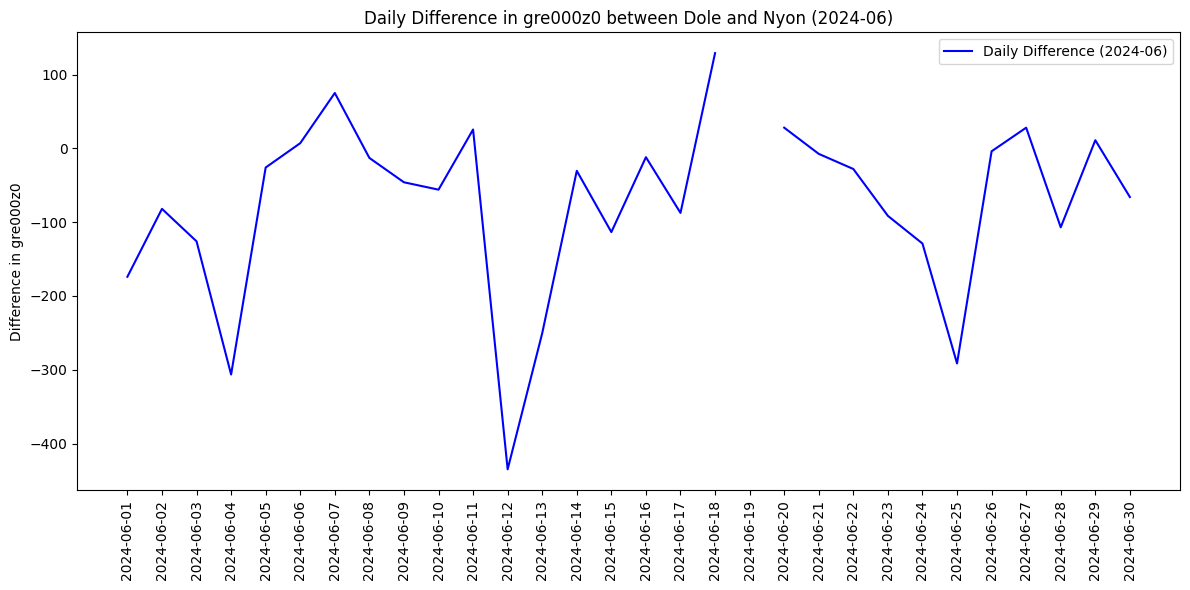

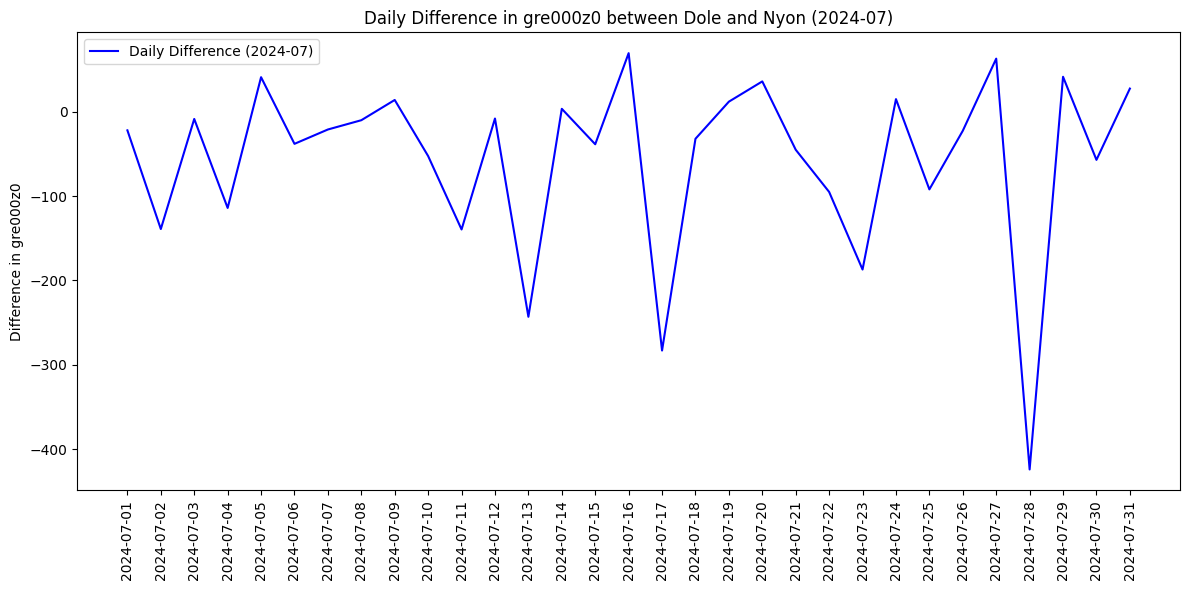

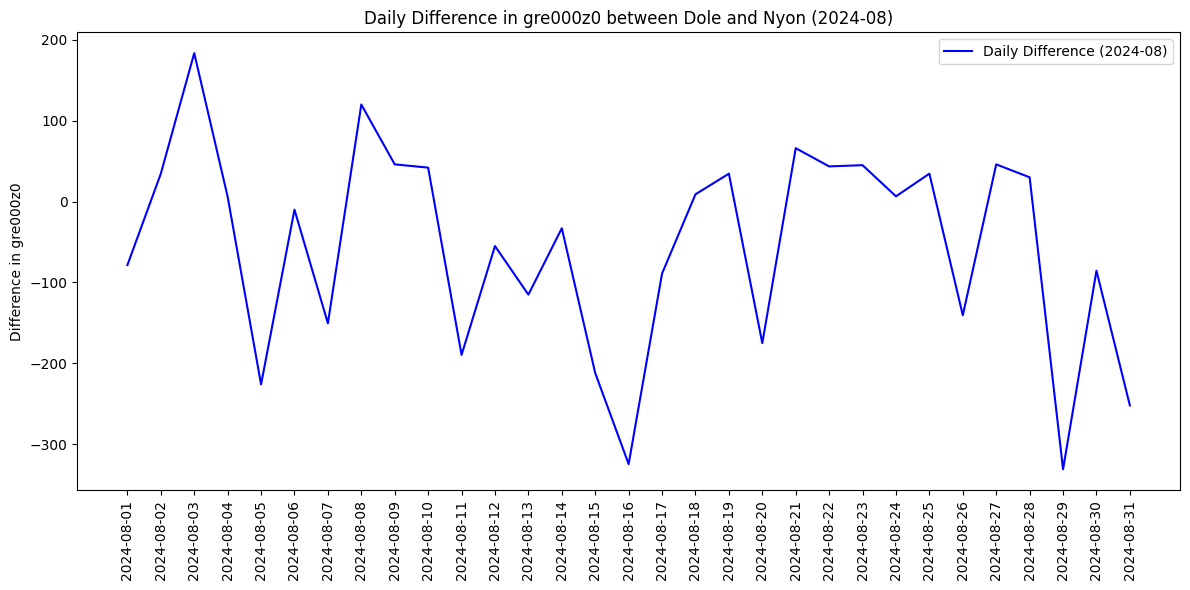

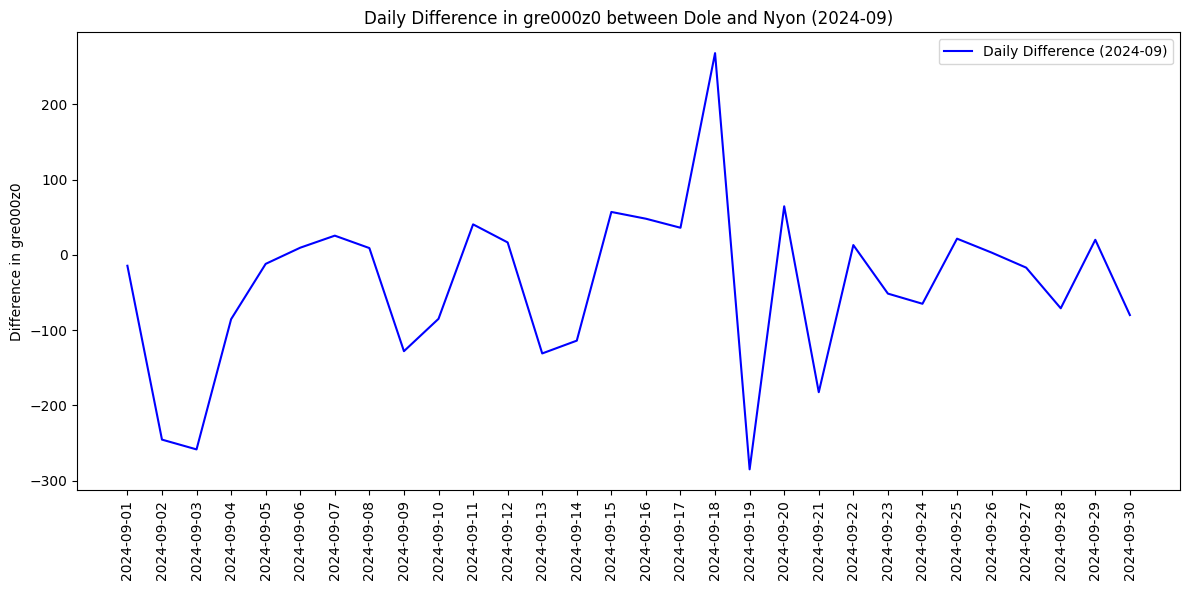

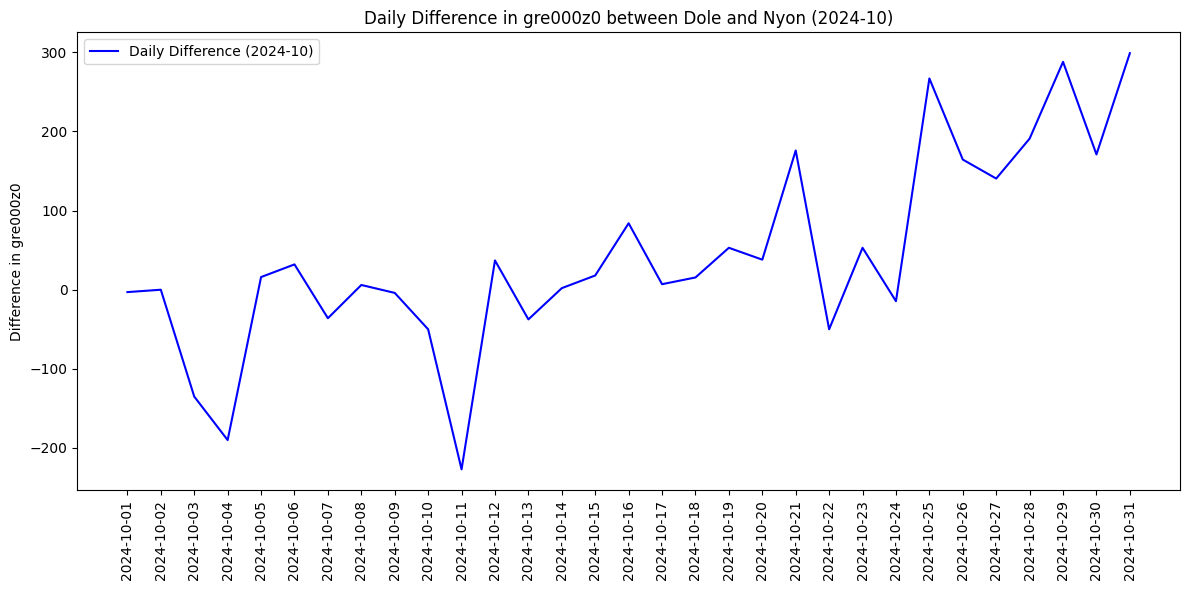

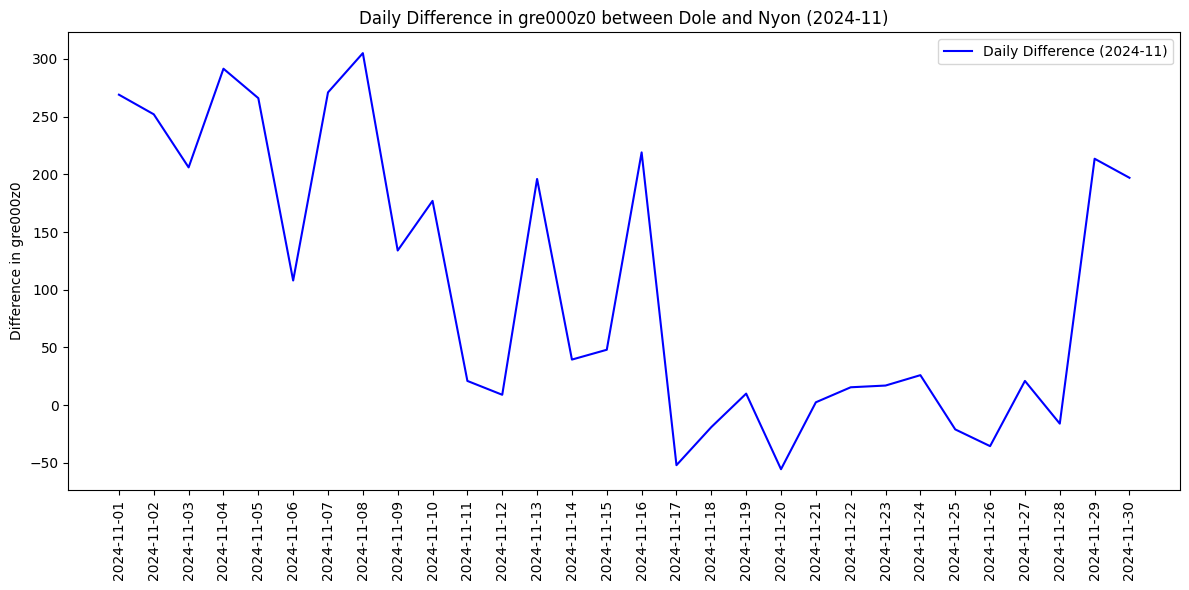

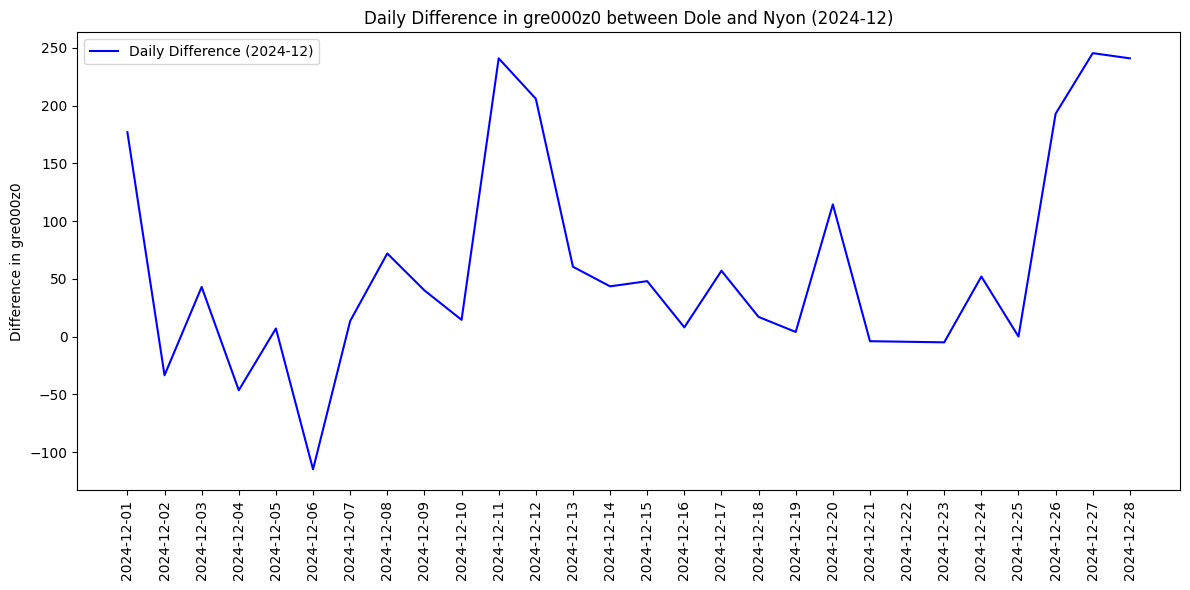

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Load the data
npz_data = np.load("data/complete_data.npz", allow_pickle=True)
# Step 2: Create a DataFrame with the data
data = npz_data['dole']
dole_data = {}
nyon_data = {}
for i in range(len(data)):
    dole_data[data[i]["datetime"]] = data[i]["gre000z0_dole"]
    nyon_data[data[i]["datetime"]] = data[i]["gre000z0_nyon"]

dole_df = pd.DataFrame.from_dict(dole_data, orient='index', columns=['gre000z0_dole'])
nyon_df = pd.DataFrame.from_dict(nyon_data, orient='index', columns=['gre000z0_nyon'])

# Step 3: Convert the index to datetime and group by day
dole_df.index = pd.to_datetime(dole_df.index)
nyon_df.index = pd.to_datetime(nyon_df.index)

dole_daily = dole_df.resample('D').median()  # Daily mean
nyon_daily = nyon_df.resample('D').median()

daily_diff = dole_daily['gre000z0_dole'] - nyon_daily['gre000z0_nyon']
print(daily_diff)
# Step 4: Group by month and plot separately
daily_diff.index = pd.to_datetime(daily_diff.index)  # Ensure datetime index
months = daily_diff.index.to_period('M').unique()  # Get unique months

for month in months:
    monthly_data = daily_diff[daily_diff.index.to_period('M') == month]
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_data.index, monthly_data.values, label=f'Daily Difference ({month})', color='blue')
    plt.xticks(ticks=monthly_data.index, labels=monthly_data.index.strftime('%Y-%m-%d'), rotation=90)
    plt.ylabel('Difference in gre000z0')
    plt.title(f'Daily Difference in gre000z0 between Dole and Nyon ({month})')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'analysis/diff/daily_difference_{month}.png')  # Save each plot

In [30]:
import numpy as np
import pandas as pd

# Step 1: Load the data
npz_data = np.load("data/train/dole_train_data_test.npz", allow_pickle=True)
npz_data_test = np.load("data/test/dole_test_data_test.npz", allow_pickle=True)
# Combine data
data = np.concatenate((npz_data['dole'], npz_data_test['dole']), axis=0)

# Step 2: Create a DataFrame with the data
dole_data = {}
nyon_data = {}
for i in range(len(data)):
    dole_data[data[i]["datetime"]] = data[i]["gre000z0_dole"]
    nyon_data[data[i]["datetime"]] = data[i]["gre000z0_nyon"]

dole_df = pd.DataFrame.from_dict(dole_data, orient='index', columns=['gre000z0_dole'])
nyon_df = pd.DataFrame.from_dict(nyon_data, orient='index', columns=['gre000z0_nyon'])

# Step 3: Convert the index to datetime
dole_df.index = pd.to_datetime(dole_df.index)
nyon_df.index = pd.to_datetime(nyon_df.index)

# Step 4: Filter data for a specific day
specific_day = "2024-11-08"  # Replace with your desired date
dole_filtered = dole_df.loc[specific_day]
nyon_filtered = nyon_df.loc[specific_day]

# Step 5: Compute the mean
mean_dole = dole_filtered['gre000z0_dole'].median()
mean_nyon = nyon_filtered['gre000z0_nyon'].median()

# Print the results
print(f"Mean gre000z0_dole for {specific_day}: {mean_dole}")
print(f"Mean gre000z0_nyon for {specific_day}: {mean_nyon}")
diff = mean_dole - mean_nyon
print(f"Difference in gre000z0 for {specific_day}: {diff}")

# Find the date(s) where the daily difference equals diff (with tolerance for float comparison)
tolerance = 6
d = 60
matching_dates = daily_diff[np.isclose(daily_diff.values, d, atol=tolerance)].index
print(f"Date(s) where the difference equals {d}: {list(matching_dates)}")


Mean gre000z0_dole for 2024-11-08: 374.0
Mean gre000z0_nyon for 2024-11-08: 69.0
Difference in gre000z0 for 2024-11-08: 305.0
Date(s) where the difference equals 60: [Timestamp('2023-01-07 00:00:00'), Timestamp('2023-01-28 00:00:00'), Timestamp('2023-02-07 00:00:00'), Timestamp('2023-02-09 00:00:00'), Timestamp('2023-02-13 00:00:00'), Timestamp('2023-02-14 00:00:00'), Timestamp('2023-02-15 00:00:00'), Timestamp('2023-02-18 00:00:00'), Timestamp('2023-03-06 00:00:00'), Timestamp('2023-03-18 00:00:00'), Timestamp('2023-03-21 00:00:00'), Timestamp('2023-03-23 00:00:00'), Timestamp('2023-04-04 00:00:00'), Timestamp('2023-04-07 00:00:00'), Timestamp('2023-05-03 00:00:00'), Timestamp('2023-08-25 00:00:00'), Timestamp('2023-10-01 00:00:00'), Timestamp('2023-10-13 00:00:00'), Timestamp('2023-10-17 00:00:00'), Timestamp('2023-11-25 00:00:00'), Timestamp('2024-02-25 00:00:00'), Timestamp('2024-03-14 00:00:00'), Timestamp('2024-03-24 00:00:00'), Timestamp('2024-04-24 00:00:00'), Timestamp('2024-0

In [94]:
# read images of 2024-11-08 and plot
import numpy as np
import matplotlib.pyplot as plt
import os
from netCDF4 import Dataset, num2date
import matplotlib.dates as mdates
# Set the date to visualize
#read npz data train file

# Combine data
date_to_plot = "2023-06-14"

# Filter the DataFrame for the selected day
dole_day = dole_df.loc[date_to_plot]
nyon_day = nyon_df.loc[date_to_plot]
# Resample to 10-minute intervals, interpolating missing values
dole_day = dole_day.resample('10T').interpolate()
nyon_day = nyon_day.resample('10T').interpolate()
times = dole_day.index

year, month, day = map(int, date_to_plot.split('-'))
# Ensure month and day are zero-padded to two digits
month = f"{month:02d}"
day = f"{day:02d}"
# Prepare the image directory and list images for the day
image_dir = f"/home/marta/Projects/tb/data/images/mch/1159/2/{year}/{month}/{day}/"
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')])

# Plotting
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.plot(times, dole_day['gre000z0_dole'], label='Dole gre000z0', color='red')
ax1.plot(times, nyon_day['gre000z0_nyon'], label='Nyon gre000z0', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('gre000z0')
ax1.set_title(f'gre000z0 for Dole and Nyon on {date_to_plot}')
ax1.legend()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)

# Add images as thumbnails at corresponding timestamps
for i, t in enumerate(times):
    # Find the image file that matches the timestamp (assuming filenames contain the time)
    img_file = next((f for f in image_files if t.strftime('%H%M') in f), None)
    if img_file:
        img_path = os.path.join(image_dir, img_file)
        img = plt.imread(img_path)
        # Place the image as an inset
        ax_img = fig.add_axes([0.05 + i*0.9/len(times), 0.6, 0.03, 0.22])
        if i % 2 == 0:
            ax_img.imshow(img)
        ax_img.axis('off')

plt.tight_layout()
fig.set_size_inches(40, 8)  # Increase figure size for all images to be visible
plt.close(fig)
fig.savefig(f"analysis/{date_to_plot}.png", dpi=150)



/tmp/ipykernel_5404/2038029663.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dole_day = dole_day.resample('10T').interpolate()
/tmp/ipykernel_5404/2038029663.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  nyon_day = nyon_day.resample('10T').interpolate()
/tmp/ipykernel_5404/2038029663.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


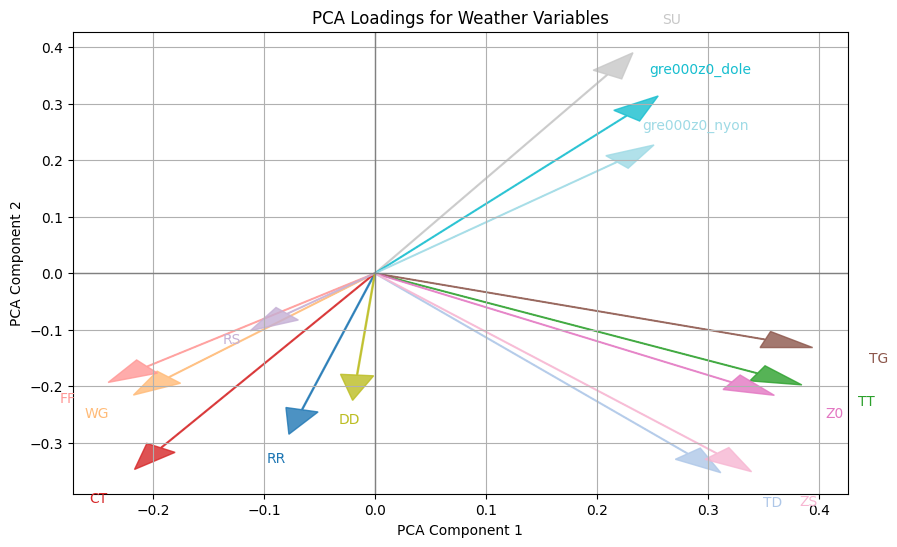

In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Select weather variables to use for PCA
weather_vars = ['RR', 'TD', 'WG', 'TT', 'CT', 'FF', 'RS', 'TG', 'Z0', 'ZS', 'SU', 'DD', 'gre000z0_dole', 'gre000z0_nyon']

# Convert the numpy array of dicts to a DataFrame
weather_df = pd.DataFrame(list(data))

# Drop rows with missing values in the selected variables
weather_df_clean = weather_df[weather_vars].dropna()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(weather_df_clean)
# Assign a unique color to each variable for plotting PCA loadings
colors = plt.cm.tab20(np.linspace(0, 1, len(weather_vars)))
pca = PCA(n_components=2)
pca.fit(X_scaled)
# Plot PCA loadings (contributions of each variable to PC1 and PC2)
plt.figure(figsize=(10, 6))
for i, var in enumerate(weather_vars):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i],
              color=colors[i], alpha=0.8, head_width=0.03, length_includes_head=True)
    plt.text(pca.components_[0, i]*1.15, pca.components_[1, i]*1.15, var, color=colors[i], ha='center', va='center')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Loadings for Weather Variables')
plt.grid()
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()

Retained information: 47.51%
Lost information: 52.49%


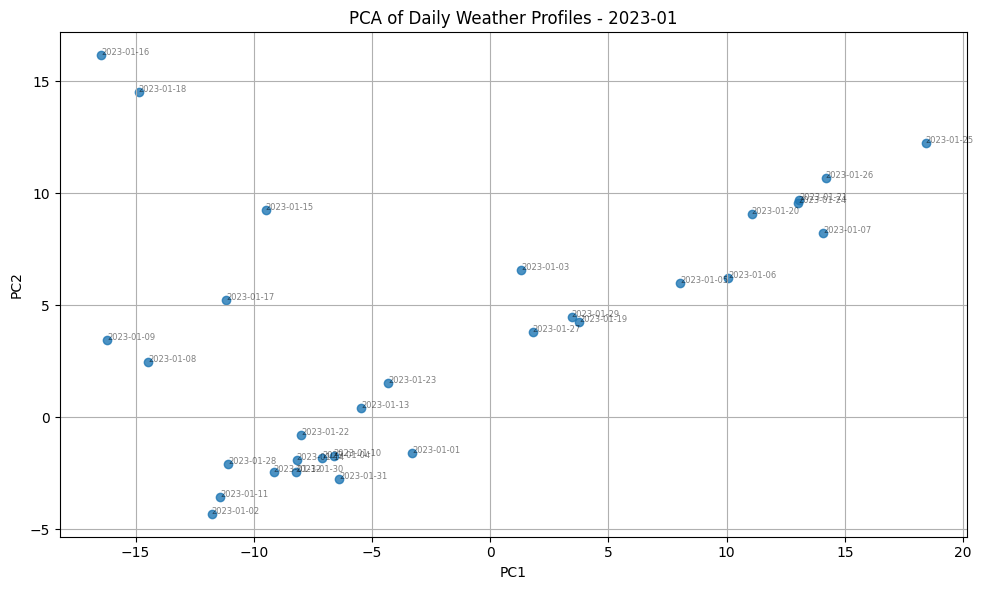

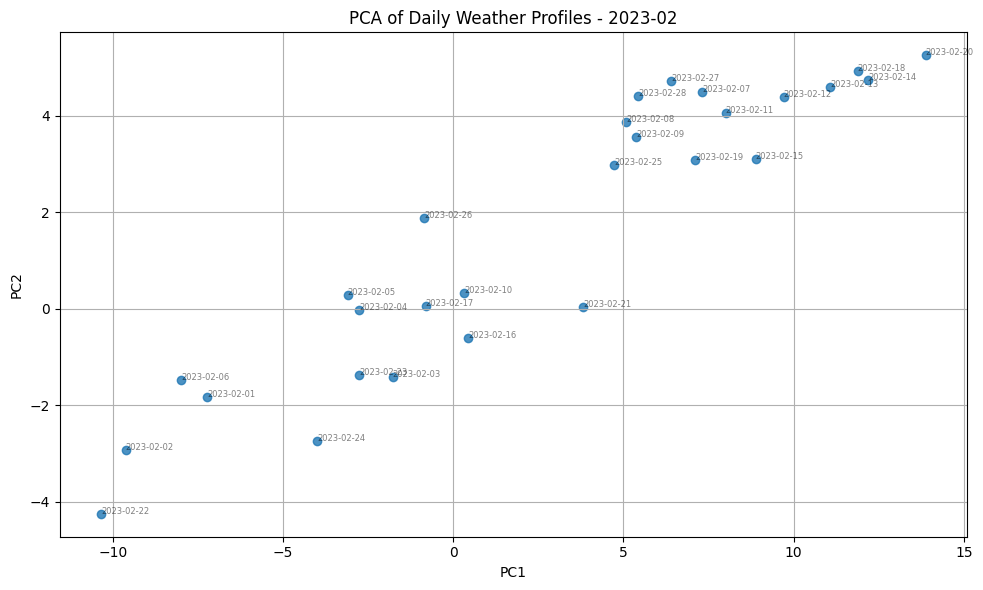

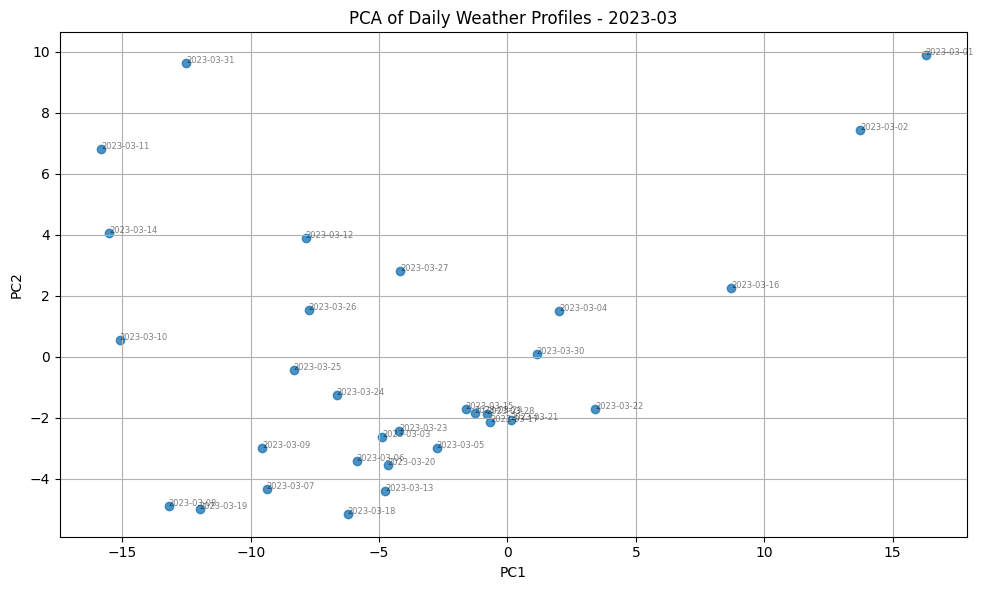

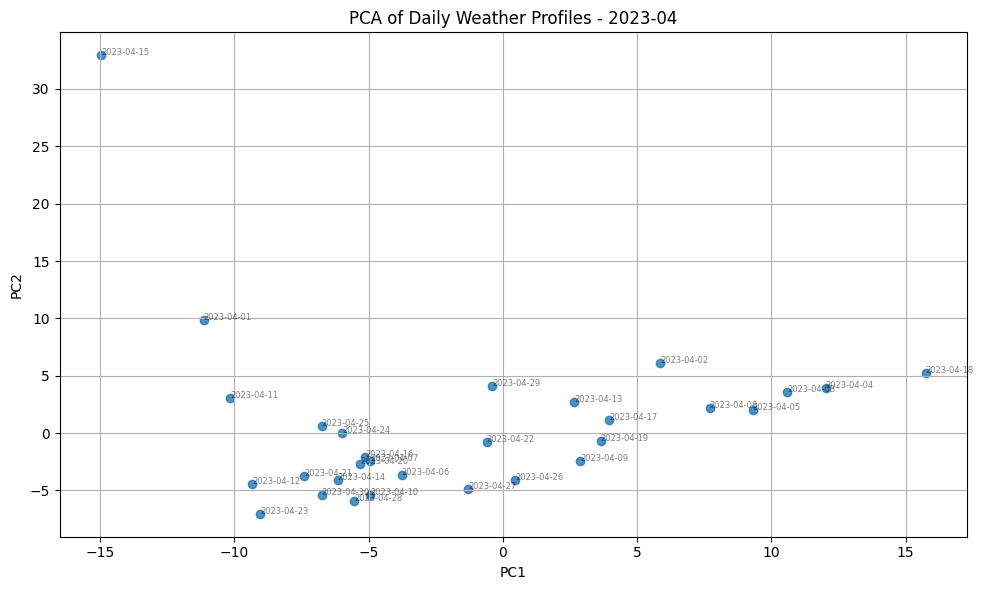

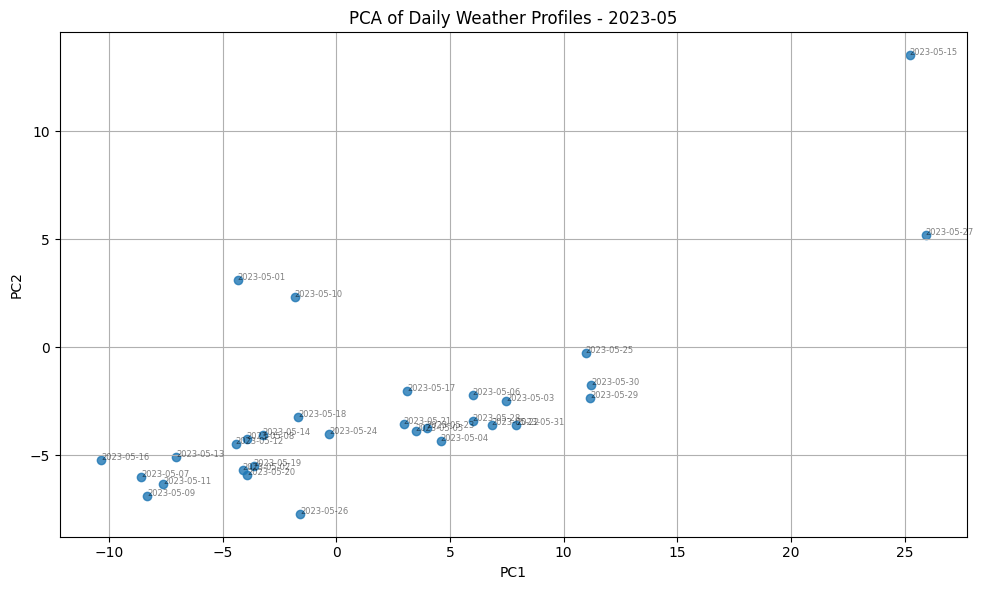

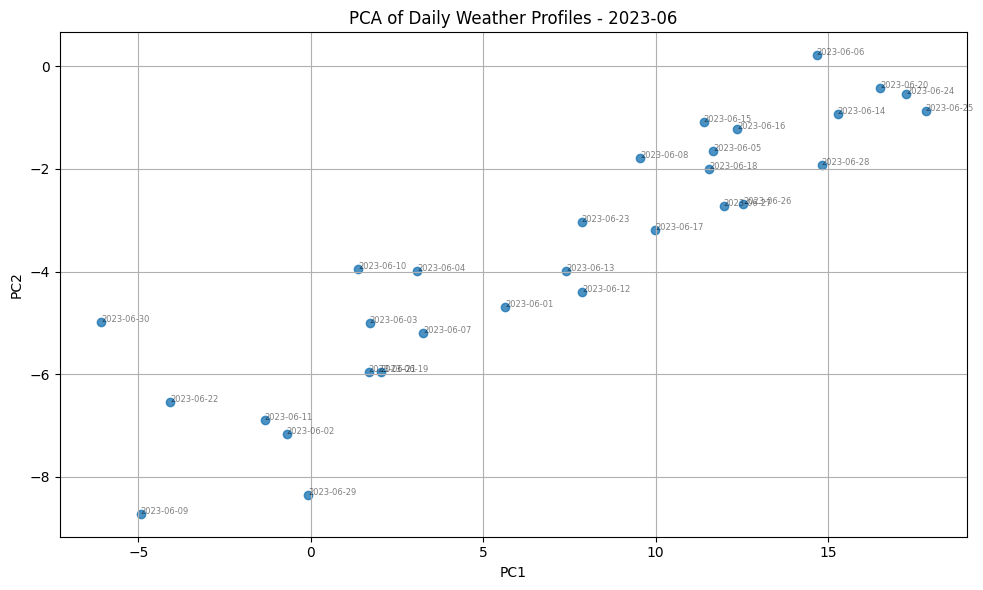

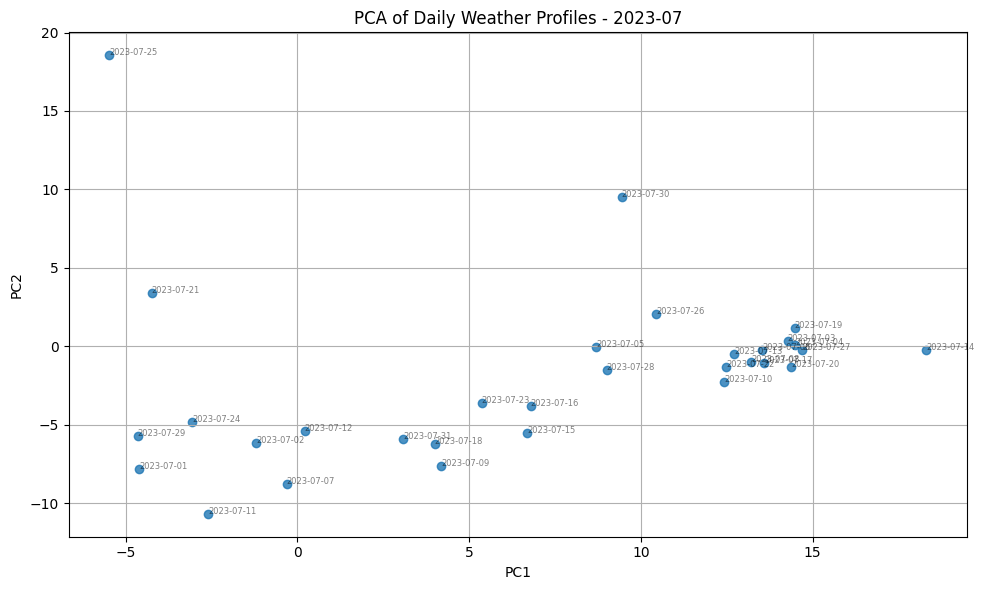

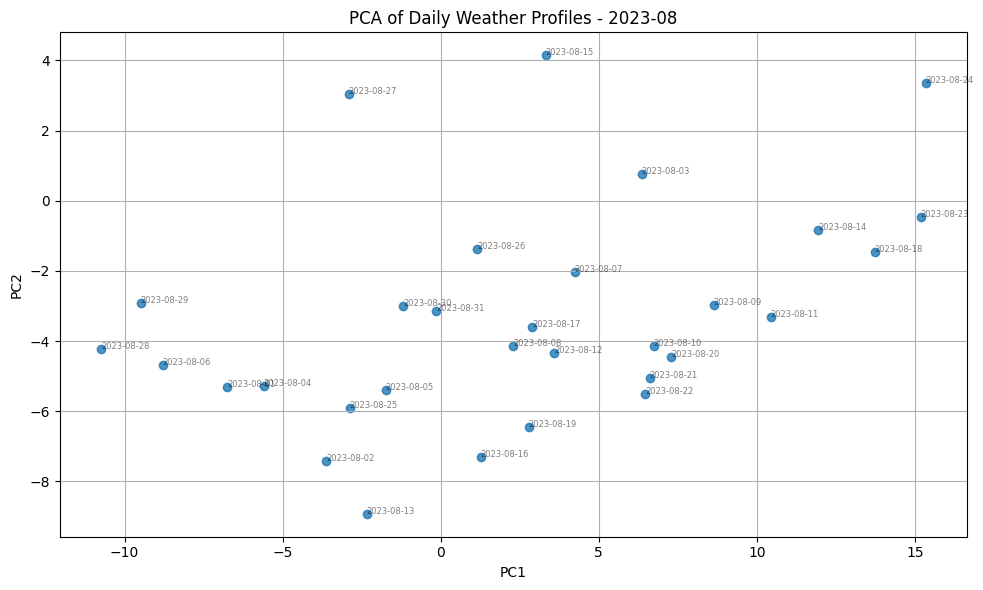

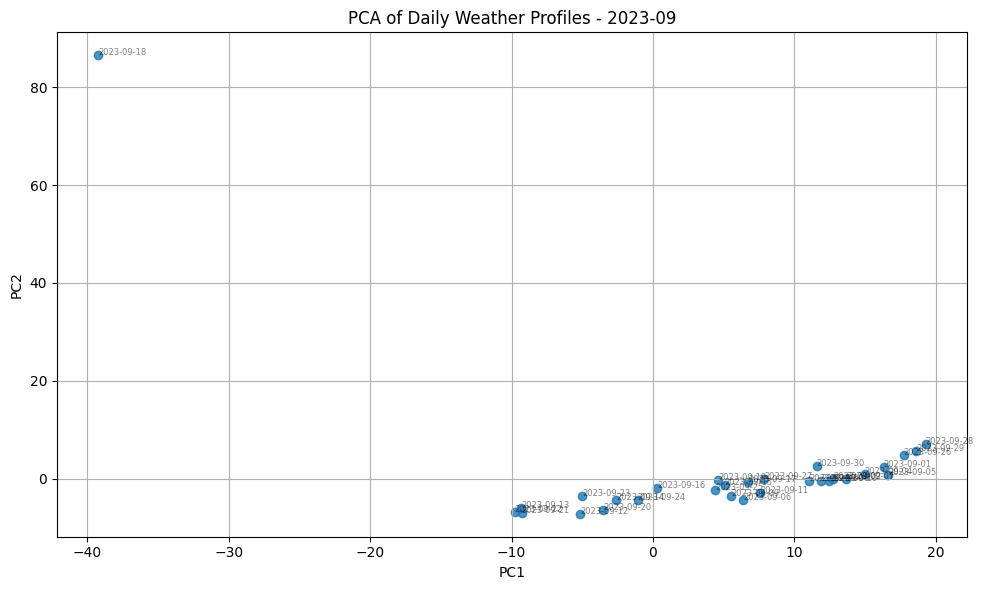

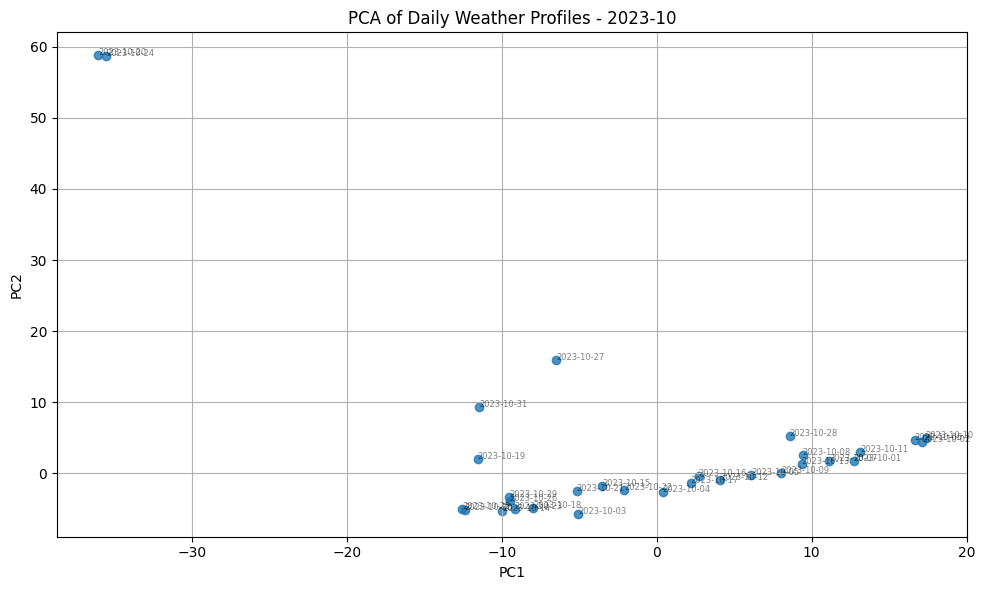

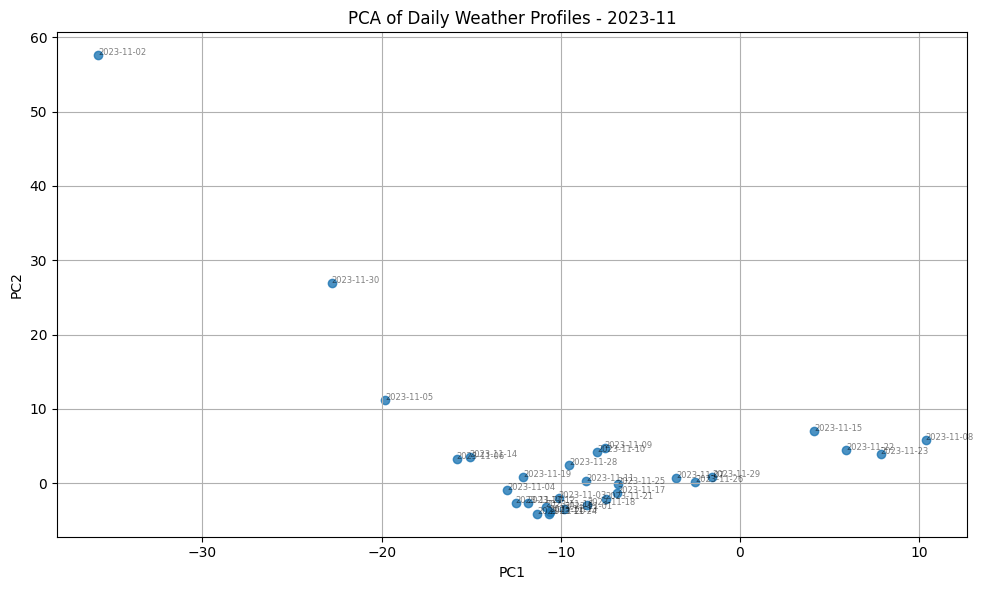

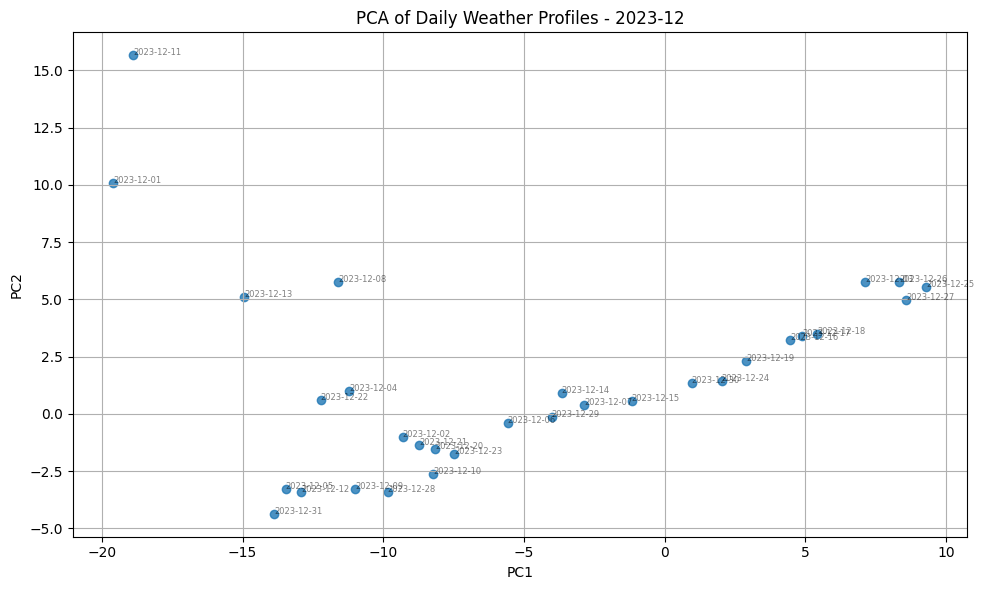

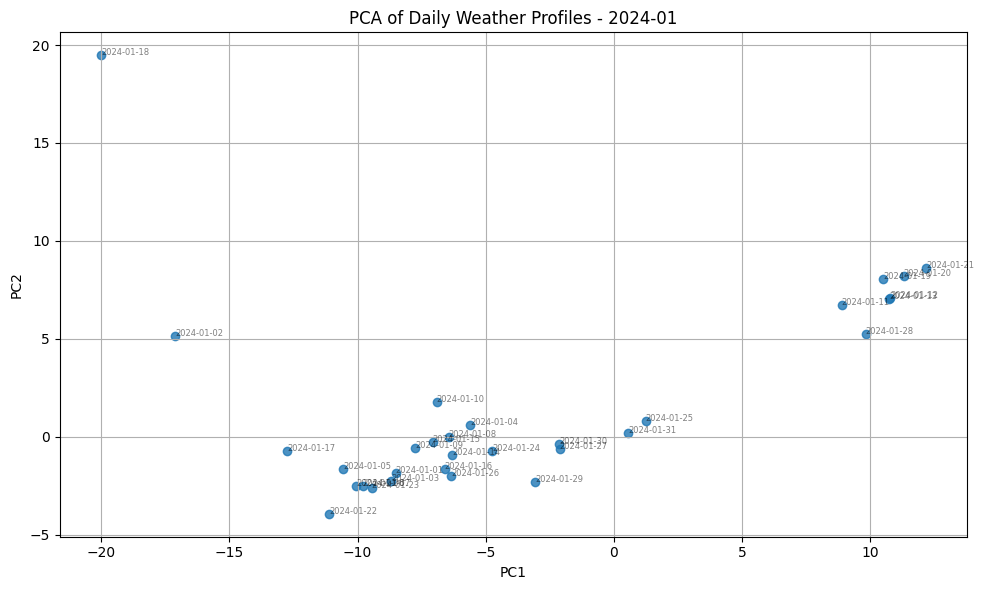

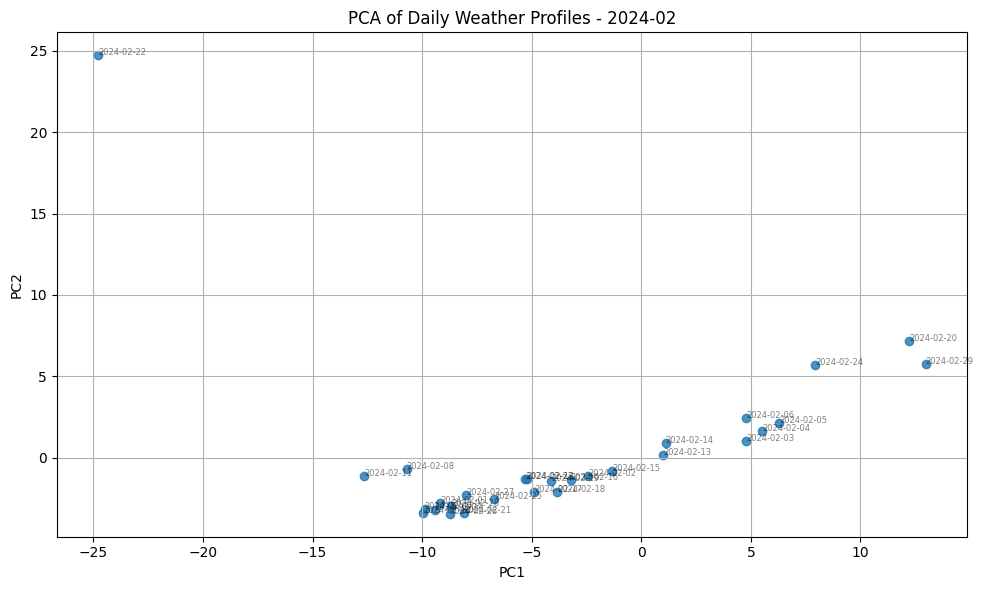

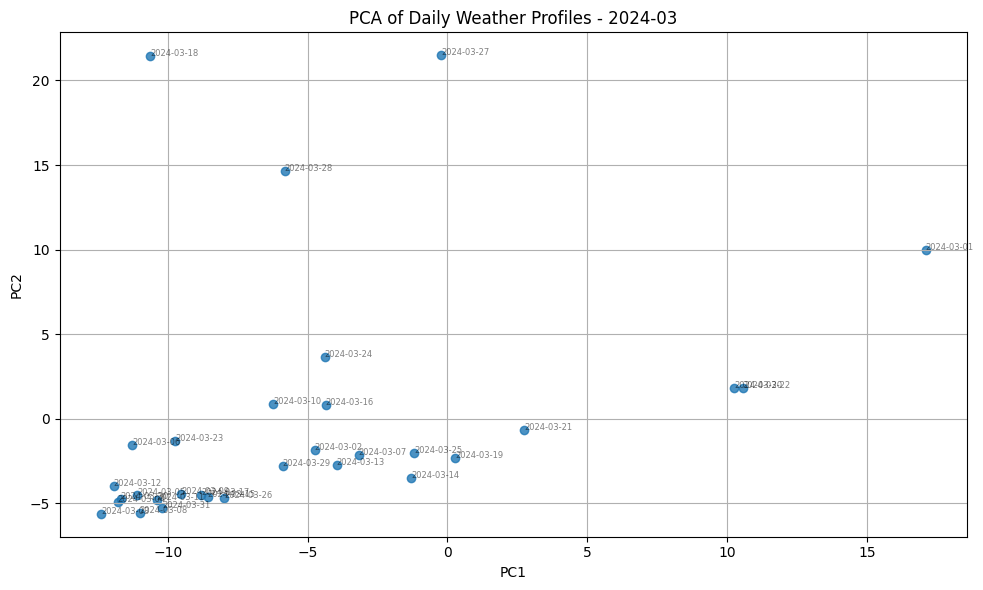

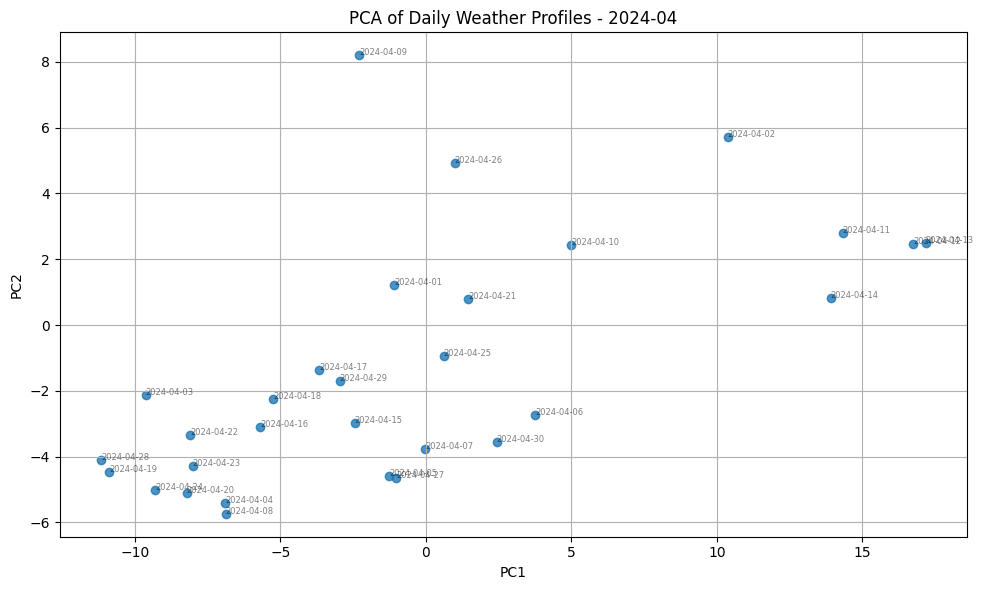

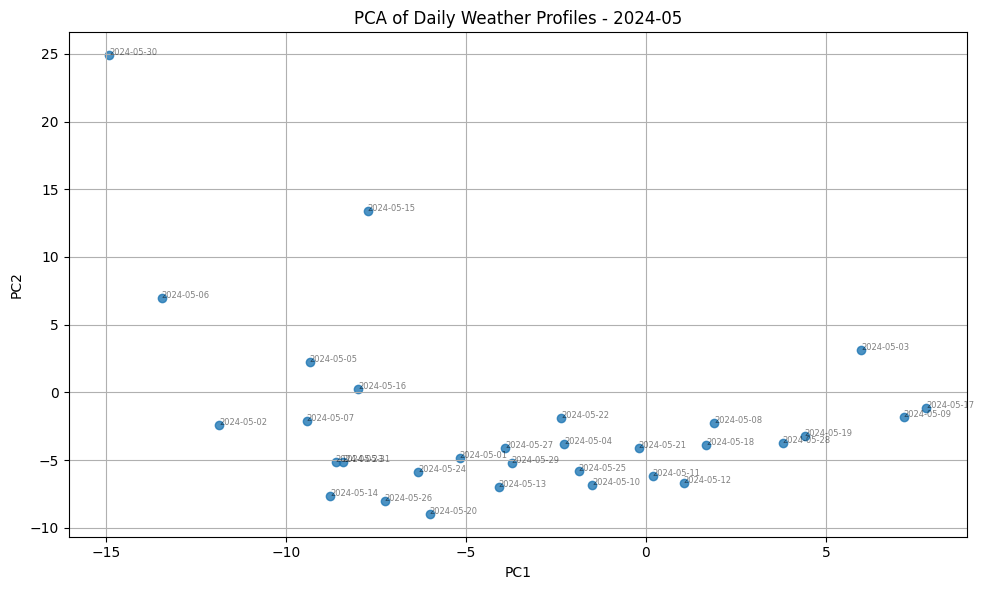

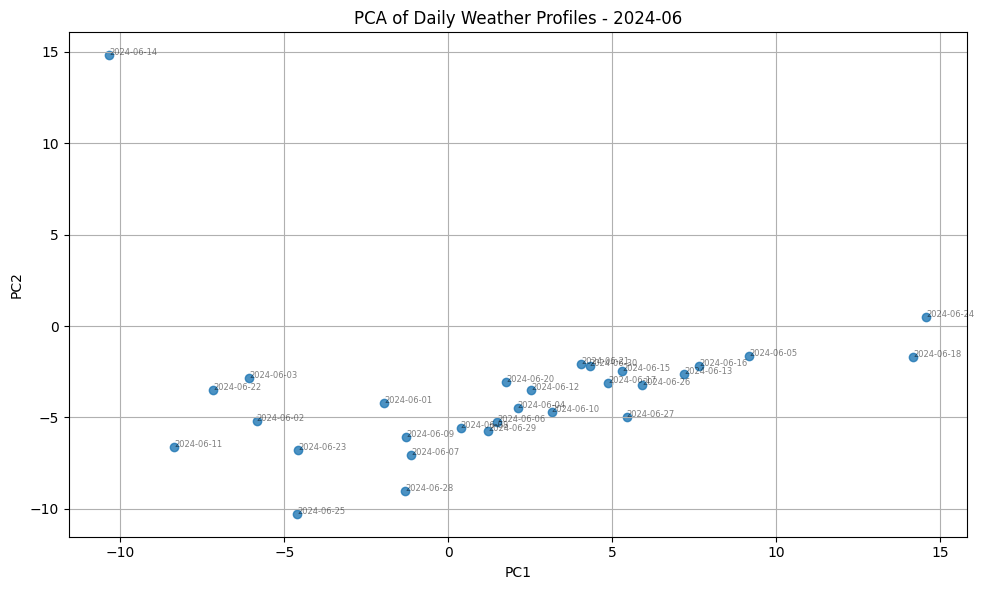

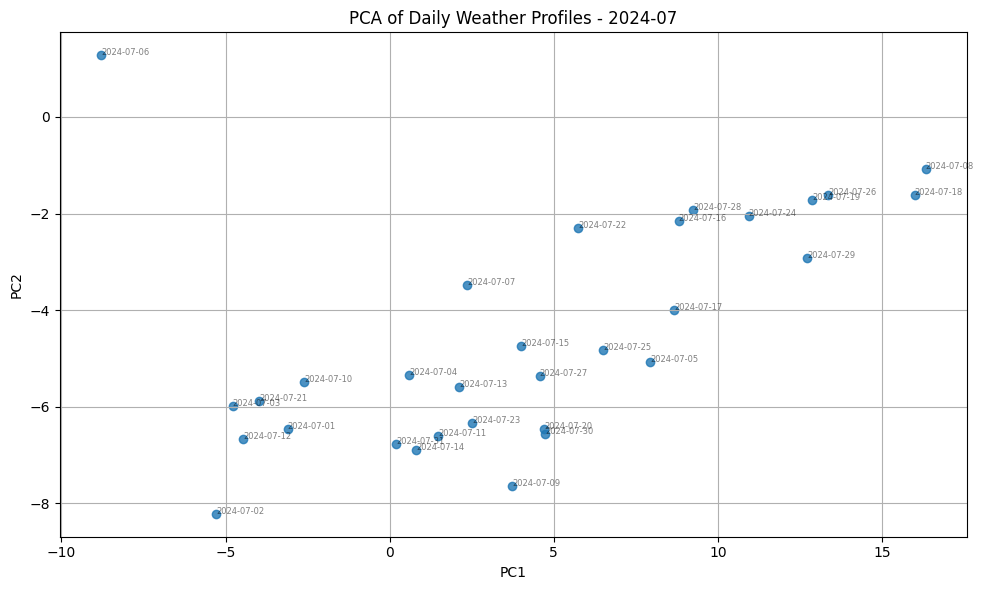

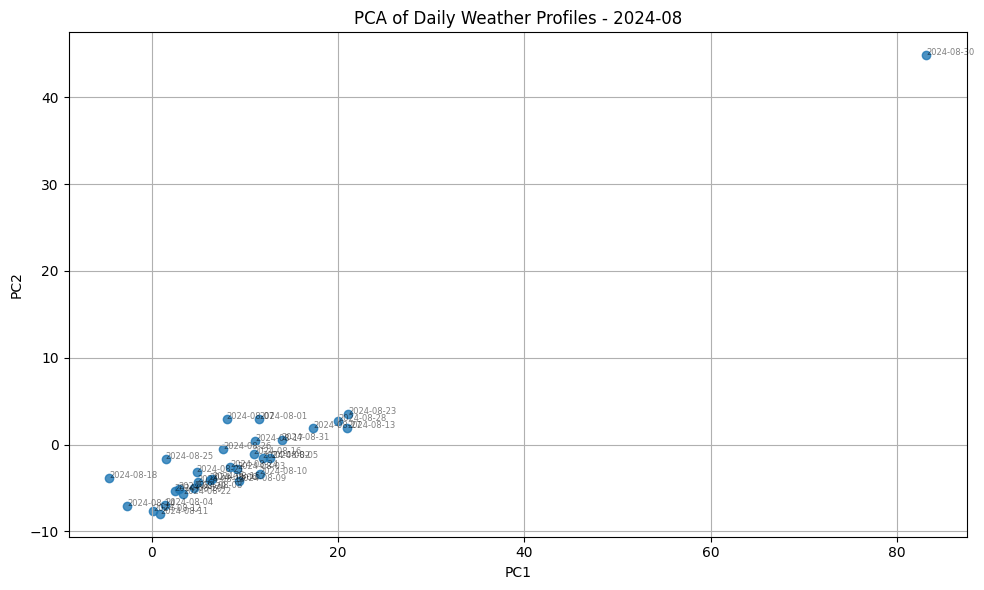

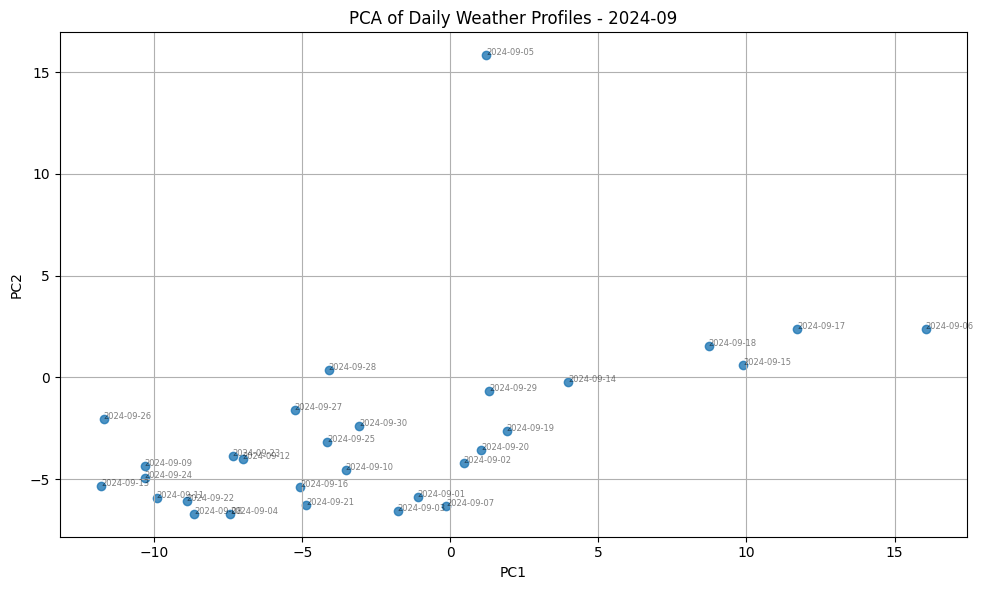

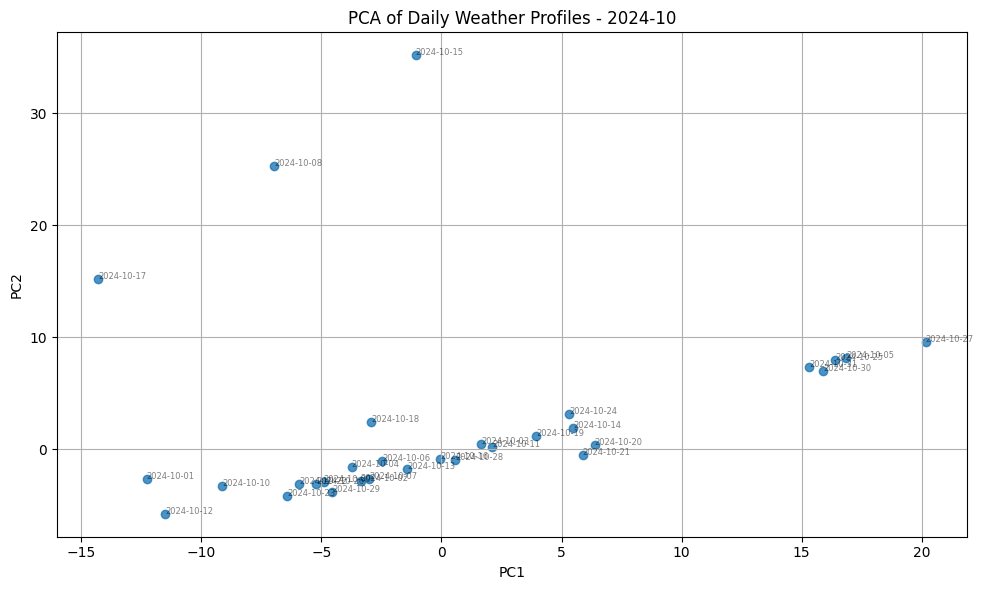

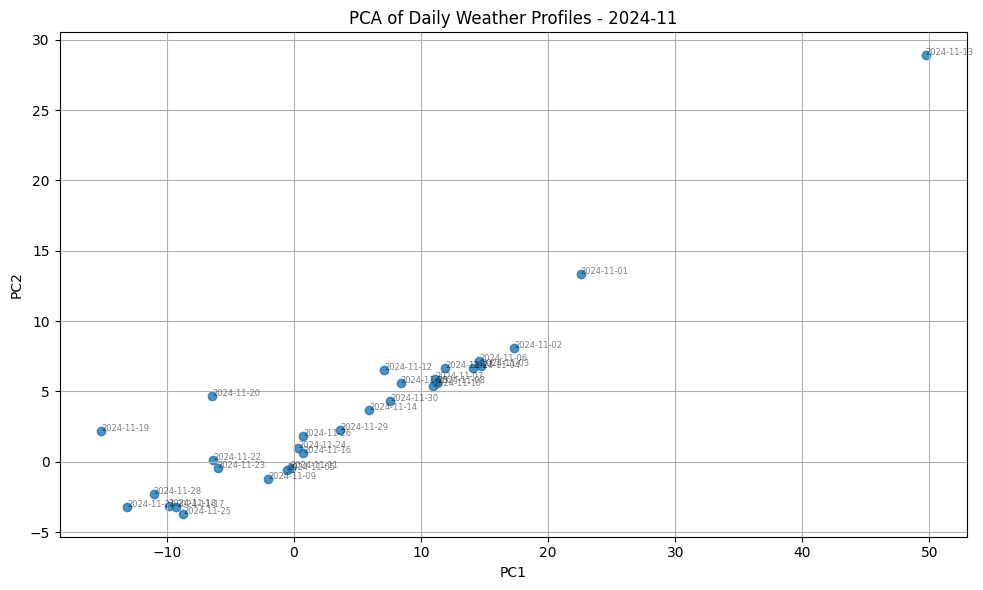

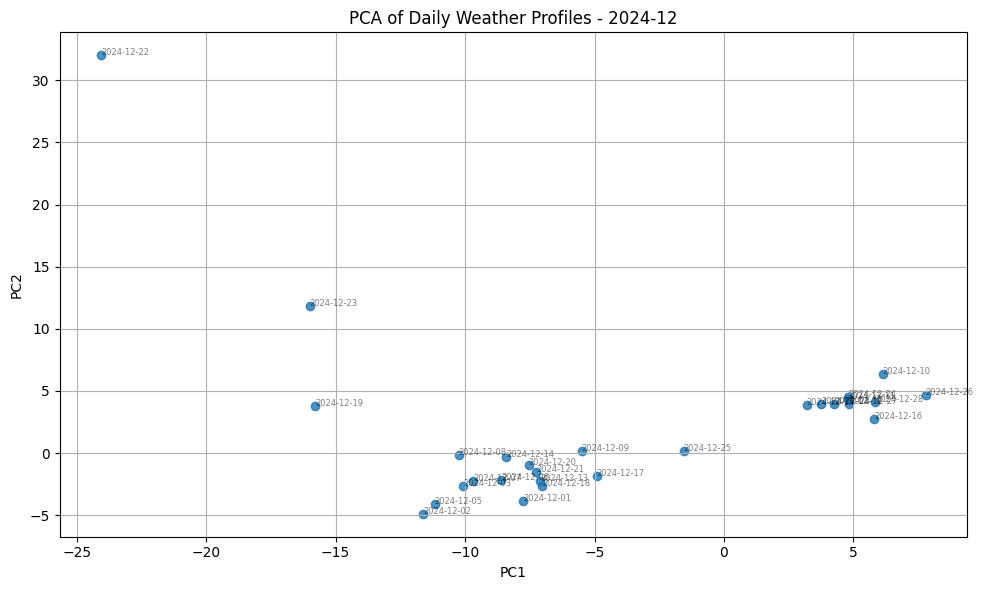

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load and preprocess
weather_df = pd.DataFrame(list(npz_data['dole']))
weather_df = weather_df.dropna(subset=['datetime'])

# Convert datetime and add date + hour
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
weather_df['date'] = weather_df['datetime'].dt.date
weather_df['hour'] = weather_df['datetime'].dt.hour

# Meteo variables to use
meteo_vars = ['RR', 'TD', 'WG', 'TT', 'CT', 'FF', 'RS', 'TG', 'Z0', 'ZS', 'SU', 'DD',
              'gre000z0_nyon', 'gre000z0_dole']

# Container for daily vectors
daily_vectors = []
valid_dates = []

# Build one feature vector per day
for date, group in weather_df.groupby('date'):
    day_vector = []
    for hour in range(24):
        hour_data = group[group['hour'] == hour]
        if hour_data.empty:
            # If no data for this hour, append NaNs for all vars
            day_vector.extend([np.nan] * len(meteo_vars))
        else:
            # If multiple entries, take the mean
            values = hour_data[meteo_vars].mean().tolist()
            day_vector.extend(values)
    daily_vectors.append(day_vector)
    valid_dates.append(date)

# Create DataFrame (one row per day)
daily_matrix = pd.DataFrame(daily_vectors, index=valid_dates)

# Fill missing values
daily_matrix = daily_matrix.interpolate(axis=1, limit_direction='both')
daily_matrix = daily_matrix.fillna(daily_matrix.mean())

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(daily_matrix)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_

retained_info = explained_variance.sum()
lost_info = 1 - retained_info


print(f"Retained information: {retained_info:.2%}")
print(f"Lost information: {lost_info:.2%}")


# Convert index to datetime to get months
daily_matrix.index = pd.to_datetime(daily_matrix.index)
months = daily_matrix.index.to_period('M').unique()

# Plot by month
for month in months:
    fig, ax = plt.subplots(figsize=(10, 6))
    month_mask = daily_matrix.index.to_period('M') == month
    scatter = ax.scatter(
        X_pca[month_mask, 0],
        X_pca[month_mask, 1],
        alpha=0.8,
        color='tab:blue'
    )
    for i in np.where(month_mask)[0]:
        ax.text(X_pca[i, 0], X_pca[i, 1], str(daily_matrix.index[i].date()), fontsize=6, alpha=0.5)

    ax.set_title(f'PCA of Daily Weather Profiles - {month}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid()
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"analysis/pca/pca_per_day_month_{month}.png", dpi=150)
    # plt.close(fig)
